## Includes factoring out the communication cost as the accumulative sum of the applying the time delay to the ESs that require receiving context events

# Installing Libraries and loading the JSON file

In [ ]:
#Approach creating task graph
!pip install numpy
!pip install pygad
!pip install deap
import numpy as np
import pygad
import random
import json
import networkx as nx
import matplotlib.pyplot as plt
from decimal import Decimal
from copy import deepcopy
from collections import defaultdict

from functools import partial
from deap import base, creator, tools, algorithms

#Read example JSON file.

from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Open the file from Google Drive
with open('/content/drive/MyDrive/example_80_N1.json', 'r') as f:
    # Load the JSON data from the file
    json_data = json.load(f)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **Scheduling the Exchange of Context Informationfor Time-Triggered Adaptive Systems**

## Helper functions

In [ ]:
def Read_Parent_AM(json_data):     # Returning a dictionary about the Application graph
  AMx = json_data['application']
  #print("The Parent AM is ",AMx)
  return AMx

def Read_Parent_PM(json_data):     # Returning a dictionary about the Platform graph
  PMx = json_data['platform']
  return PMx


def construct_communication_costs_from_json(json_data):
  messages = json_data['application']['messages']
  communication_costs = {}

  for message in messages:
      sender = message['sender']
      receiver = message['receiver']
      size = message['size']

      if sender not in communication_costs:
          communication_costs[sender] = {receiver: size}
      else:
          communication_costs[sender][receiver] = size

  return communication_costs

def construct_task_dag_from_json(APP_MODEL): # where APP_MODELis an instance from the function Read_Parent_AM(json_data)
    # this function returns 2 lists one for task_dag (list of lists) for the successors
    # Another list tis the wcet_values showing the worst excution times for each job
    jobs = APP_MODEL['jobs']
    messages = APP_MODEL['messages']

    num_tasks = len(jobs)

    # Create a mapping of sender and receiver tasks for each message
    message_mapping = {}
    for message in messages:
        sender = message['sender']
        receiver = message['receiver']
        if sender not in message_mapping:
            message_mapping[sender] = [receiver]
        else:
            message_mapping[sender].append(receiver)

    # Create the task DAG
    task_dag = [[] for _ in range(num_tasks)]

    for job_id, successors in message_mapping.items():
        task_dag[job_id] = successors

    # Extract the WCET values
    wcet_values = [job['processing_times'] for job in jobs]

    return task_dag, wcet_values


def extract_message_list(APP_MODEL):
  # Returns a list of dictionaries for each meassage attribute where the keys for each message will be
  # id,sender,reciever,size
    messages = APP_MODEL['messages']                              # feteching messages (list of dictionaries)
    task_ids = [job['id'] for job in APP_MODEL['jobs']]           # creating a list of task_ids
    message_list = []                                                            # Initializing a list
    for msg in messages:
        sender_id = task_ids.index(msg['sender'])
        receiver_id = task_ids.index(msg['receiver'])
        message_size = msg['size']
        message_id = msg['id']
        message_info = {
            'id': message_id,
            'sender': sender_id,
            'receiver': receiver_id,
            'size': message_size
        }
        message_list.append(message_info)
    return message_list

def compute_makespan(schedule):    # passing the Re-construction function result
    # Extract end times from the schedule
    end_times = [info[2] for info in schedule.values()]
    # The makespan is the maximum end time
    makespan = max(end_times)
    return makespan

def plot_schedule(schedule):
    fig, ax = plt.subplots()

    processors = sorted(list(set([processor for processor, _, _ in schedule.values()])))
    colors = plt.cm.tab10(np.linspace(0, 1, len(processors)))

    for task, (processor, start_time, end_time) in schedule.items():
        color = colors[processor]
        ax.plot([start_time, end_time], [task, task], label=f'Processor {processor}', linewidth=10, marker='o', color=color)

    ax.set_xlabel('Time')
    ax.set_ylabel('Task')

    # Calculate the makespan and set x-axis limit
    makespan = max(end_time for _, (_, _, end_time) in schedule.items())
    ax.set_xlim(0, makespan)

    # Set y-axis ticks and labels
    plt.yticks(range(len(schedule)))
    plt.grid()
    plt.title("Task Schedule")

    # Create a custom legend without duplicate labels
    handles, labels = ax.get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    ax.legend(by_label.values(), by_label.keys())

    plt.show()

def construct_graph_from_json(PLAT_MODEL):         # Function for constructing the PM , returns a graph object
    # Extract nodes and links from JSON data
    nodes = PLAT_MODEL['nodes']
    links = PLAT_MODEL['links']

    # Create an empty graph
    graph = nx.Graph()

    # Add nodes to the graph
    for node in nodes:
        node_id = node['id']
        node_type = 'processor' if not node['is_router'] else 'switch'
        graph.add_node(node_id, node_type=node_type)

    # Add edges (links) to the graph
    for link in links:
        start = link['start']
        end = link['end']
        graph.add_edge(start, end)

    return graph

def generate_all_path_indexes_with_costs(graph):                           # Passing the PM as an argument , geneartes all paths between processors in the graph while calcualting the cost
    processors = [node for node, data in graph.nodes(data=True) if data['node_type'] == 'processor']
    # creating a list with the processor nodes ids
    switches = [node for node, data in graph.nodes(data=True) if data['node_type'] == 'switch']
    # creating a list with the switche nodes ids

    def find_all_paths(source, target, path=[]): # A recursive function to find all paths between a give source node and target node, source and target are the iterables from the below for loop
      # This function uses a depth first search (DFS) to explore the paths
        path = path + [source]                    # Appending the "source" node to the path list, to keep track of nodes vistied in the list
        if source == target:
            return [path]
        if source not in graph:                    # checks for node presence in graph
            return []
        paths = []
        for node in graph[source]:                 # iterating through the current neighbors in graph
            if node not in path:
                newpaths = find_all_paths(node, target, path)  # calling the fuction recursively taking the neighbor node as a source node , target node is the same as the old one, path= path calculated so far
                for newpath in newpaths:
                    paths.append(newpath)
        return paths

    path_indexes = {}                             # Initialzing a dict. to store results (paths and costs)
    path_id = 0
    for source in processors:                     # iterating through the processors list in the PM [0,1,2]
        for target in processors:                 # iterating through processors list in PM [0,1,2], done to consider all pairs between source and target nodes
            if source != target:                  # checking if source and target nodes are not the same as we don't need a path from the processor to itself
                all_paths = find_all_paths(source, target)
                all_paths = [path for path in all_paths if any(node in path for node in switches)] # filtering the paths to keep the ones with only one switch node
                if all_paths:
                    for path in all_paths:
                        # Compute the cost as the number of edges in the path
                        path_cost = len(path) - 1                                   # Computing the cost by subtracting 1 from the number of nodes in the path.
                        # Add the path, its ID, and its cost to the result
                        path_indexes[path_id] = {"path": path, "cost": path_cost}
                        path_id += 1
    return path_indexes

#Python function for n-bit
def value_to_nbit_vector(value, n): # representing teh context event in bit form
    binary = bin(value)[2:]  # Remove the '0b' prefix
    binary = binary.zfill(n)  # Pad with leading zeros to make it n bits long
    bit_vector = [int(bit) for bit in binary]  # Convert each character to integer, bit representation
    return bit_vector

#python function to return the highest bit set (To decode which context event we are dealing with. The value of c)
def find_msb_position(bit_vector):
    msb_position = 0
    for i in range(len(bit_vector)):
        if bit_vector[i] == 1:
            msb_position = len(bit_vector) - i
            break
    return msb_position

#function to convert bit_vector to integer
def bit_vector_to_value(bit_vector):
    value = 0
    n = len(bit_vector)
    for i in range(n):
        value += bit_vector[i] * (2 ** (n - i - 1))
    return value


#This function is to find the equivalent binary value of c bit pattern
def msb_only_bit_vector(bit_vector):
    # Find the position of the most significant bit
    msb_position = find_msb_position(bit_vector)

    # Create a new bit vector with all bits set to 0
    new_bit_vector = [0] * len(bit_vector)

    # Set only the most significant bit to 1
    if msb_position > 0:
        new_bit_vector[-msb_position] = 1

    return new_bit_vector

def getparent(p):# where B is the Database indices and p is the schedule index
  # Assuming p is integer
  Schedule_index = p
  #print('Schedule_index', Schedule_index)
  Context_event_dec = find_msb_position(Schedule_index)
  #print('Context_event_dec', Context_event_dec)


  Context_event_Bin = msb_only_bit_vector(Schedule_index)
  #print("Context_event_Bin",Context_event_Bin)
  Parent_Schedule_Bin = sub_list(Schedule_index,Context_event_Bin)
  #print("Parent_Schedule_Bin",Parent_Schedule_Bin)
  Parent_Schedule_dec = bit_vector_to_value(Parent_Schedule_Bin)
  #print("Parent_Schedule_dec",Parent_Schedule_dec)
  return Parent_Schedule_Bin,Parent_Schedule_dec

def sub_list(list1, list2):                                                # Helper function called in getpredecessors(p)
    if len(list1) != len(list2):
        raise ValueError("Input lists must have the same length")

    result = [a - b for a, b in zip(list1, list2)]
    return result

def Apply_Context(AMx,PMx,p,contextList): # AMx= application model , PMx = Platform model, p = Parent Schedule index in binary
  jobs = AMx['jobs']
  #print("The p in the Apply_Context function is ",p)
  context_event = find_msb_position(p)
  #print("The context event  is :",context_event)
  for context in range(len(contextList)):
    if context == context_event and contextList[context][0] == 0:
      #print("The event {} is a SLACK!!".format(contextList[context]))
      for job in jobs:
        #print(job)
        if job["id"] == contextList[context][1]:
          job["processing_times"]= int(round(job["processing_times"]* (100-contextList[context][2])/100))


          #print("The new AM is : ",AMx)
    elif context == context_event and contextList[context][0] == 1:
      print("The event {} is a Failure!!".format(contextList[context]))
  #print("Function Apply_Context successively applied!!")
  return AMx,PMx

def getPredecessors(p,B): # where the first argument is Binary Encoding of the Schedule, and the second argumet is the Dataset
  Parent_Schedule_Bin,Parent_Schedule_dec = getparent(p) # Calling the helper function to return the parent schedule as decimal and binary value
  #print("The Parent Schedule of {} is {} in binary format and is {} in decimal format".format(p,Parent_Schedule_Bin,Parent_Schedule_dec))   # print check
  context_c = find_msb_position(Parent_Schedule_Bin)    # Getting the context event value of the parent schedule
  #print("The context event of the Parent Schedule is : ",context_c)                      # print check
  for i in range (len(B)): # iterating through the dataset
    if B[i][3] == Parent_Schedule_dec:
      AM,PM = B[i][1], B[i][2]
      #print("Function getPredecessor successfuly deployed ")
      #print("The AMx is {} and the PMx is {}".format(AMx,PMx))

      return AM,PM
      #print("Function getPredecessor successfuly deployed ")
  return None,None


def GA_SOLVE(AMy,PMy,SMx,Data,contextList,Current_Context_event):                             # 29.09.23 ==> adding the Context List &  Current_Context_event attributes
  successors, processing_times = construct_task_dag_from_json(AMy)
  message_list = extract_message_list(AMy)
  PLATFORM_GRAPH_OBJECT = construct_graph_from_json(PMy)
  all_path_indexes_with_costs = generate_all_path_indexes_with_costs(PLATFORM_GRAPH_OBJECT)
  n_tasks = len(processing_times)

  #SMy = generate_schedule_base_schedule(processing_times, message_list, all_path_indexes_with_costs)  # INVOKING GA
  SMy, Genome, affected_list2 = generate_Successor_schedule(processing_times, message_list, all_path_indexes_with_costs,Data,contextList,Current_Context_event)       # 29.09.23 Adding the context lIst & Current_Context_event attributes
  return SMy , Genome ,affected_list2

# TEST FUNCTIONS

#AMx = Read_Parent_AM(json_data)
#PMx = Read_Parent_PM(json_data)
##print(AMx)
#print(PMx)
#type(AMx)
#successors, processing_times = construct_task_dag_from_json(AMx)
#print(successors)
#print(processing_times)
#message_list = extract_message_list(AMx)
#print(message_list)
#PLATFORM_GRAPH_OBJECT = construct_graph_from_json(PMx)
#print(PLATFORM_GRAPH_OBJECT)
#all_path_indexes_with_costs = generate_all_path_indexes_with_costs(PLATFORM_GRAPH_OBJECT)
#print(all_path_indexes_with_costs)

## Functions Instances

In [ ]:
AMx = Read_Parent_AM(json_data)
PMx = Read_Parent_PM(json_data)
successors, processing_times = construct_task_dag_from_json(AMx)
message_list = extract_message_list(AMx)
PLATFORM_GRAPH_OBJECT = construct_graph_from_json(PMx)
all_path_indexes_with_costs = generate_all_path_indexes_with_costs(PLATFORM_GRAPH_OBJECT)
n_tasks = len(processing_times)

## Algorithm (3)
Schedule Reconstruction

In [ ]:
def reconstruct_schedule_with_precedenceX(task_allocation, node_list, processing_times, message_list, message_path_index, all_path_indexes_with_costs, message_priority_ordering):
    # Create a deep copy of the message_list to avoid modifying the original data
    message_list_copy = deepcopy(message_list)            #creating a copy of the message list

    num_processors = max(task_allocation) + 1             # specifing the number of processors
    processors = [[] for _ in range(num_processors)]      # creating a list of empty lists of size = processors

    for task, processor in enumerate(task_allocation):    # Appending the list of processor
        processors[processor].append(task)

    schedule = {}                                         # Initializing a dictionary for the new schedule.
    task_completion_times = [0] * len(node_list)          # Initializing a list of zeros with size = node list
    message_dict = defaultdict(list)                      # creating an instance of defaultdict, it allows define a default value for keys that do not yet exist in the dictionary.
    for i in range(n_tasks):
        message_dict[i] = []                              # Initializing with all potential receivers


    # Create a dictionary to map message ID to priority
    #message_priority_dict = {idx: priority for priority, idx in enumerate(message_priority_ordering)}
    # Modify the message_priority_dict to use actual message IDs
    message_priority_dict = {message_id: priority for priority, message_id in enumerate(message_priority_ordering)}       # Mapping messages to priorities


    for idx, message in enumerate(message_list_copy):
        # Decode the message path index to the corresponding path index
        path_id = message_path_index[idx]
        path = all_path_indexes_with_costs[path_id]["path"]

        path_cost= all_path_indexes_with_costs[path_id]["cost"]

        # Adjust the size of the message with the cost of the path
        message["size"] += path_cost

        # Append a tuple containing the sender, message size, and message priority to the receiver's list in the message_dict
        #message_dict[message["receiver"]].append((message["sender"], message["size"], message_priority_dict[idx]))

        # Use message["id"] to get the priority from message_priority_dict
        message_dict[message["receiver"]].append((message["sender"], message["size"], message_priority_dict[message["id"]]))

    # Sort each receiver's list in message_dict by message priority
    for receiver, messages in message_dict.items():
        message_dict[receiver] = sorted(messages, key=lambda x: x[2])

    current_time_per_processor = [0] * num_processors                 # initilaizing a list of zeros of size = No. of processors
    completed_tasks = set()                                           # creating an empty set for the completed tasks
    ready_tasks = set(range(len(node_list)))                          # A set of random numbers of size = length of node list

    while ready_tasks:                                                # iterating through the set of tasks
        task = ready_tasks.pop()                                      # Acessing a task randomly and removing it from ready tasks set
        task_id = node_list[task]                                     # getting the task id
        processor = task_allocation[task]                             # Acessing the processor on which task should run
        i = processor                                                 # Assigning the value of processor to i

        predecessors = message_dict[task_id]                          # returns a tuple of [(sender,size,id)]
        if all(p in completed_tasks for p, _, _ in predecessors):     # Checks if all pre-decessors(sender in the tuple of predecessors) are in completed tasks set
            if predecessors:
                # Ensure that the start_time is at least the end_time of the last task on this processor
                start_time = max(current_time_per_processor[i], max(task_completion_times[sender] + size for sender, size, _ in predecessors))
            else:
                start_time = current_time_per_processor[i]

            end_time = start_time + processing_times[task_id]
            schedule[task_id] = (i, start_time, end_time)
            task_completion_times[task_id] = end_time

            current_time_per_processor[i] = end_time
            completed_tasks.add(task_id)
        else:
            ready_tasks.add(task)

    return schedule

## Generating Base Schedule (Algorithm (2))

In [ ]:
def generate_schedule_base_schedule(processing_times, message_list, all_path_indexes_with_costs):

  creator.create("FitnessMin", base.Fitness, weights=(-1.0,))     # creating a FitnessMin class for minimization and setting the weights to (-1.0,).
  creator.create("Individual", list, fitness=creator.FitnessMin)  # creating the Individual class as a list with the FitnessMin class as the fitness attribute.

  toolbox = base.Toolbox()

  #parameters
  num_tasks = len(processing_times)                               # No of jobs in task graph
  nodes = json_data["platform"]["nodes"]                          # Accessing the nodes of the Platform model
  #processors = [node for node in nodes if not node["is_router"]]  # Creating  a list of the processors in the Platform model.
  num_machines = 2                              # A variable specifing the number of machines
  num_message = len(message_list)                                 # A varible = No. of messages
  num_paths = len(all_path_indexes_with_costs)                    # total number of paths

  # Define the initialization function for the individual
  def init_individual():
      return random.sample(range(num_tasks), num_tasks)           # returns a list of random numbers in the range of num_tasks

  print('The initial Indidvidual is {}'.format(init_individual()))  # OMAR

  # Register the initialization function in the DEAP toolbox
  toolbox.register("task_order", init_individual)

  #toolbox.register("task_order", tools.initIterate, creator.Individual, init_individual)

  #toolbox.register("task_order", random.sample, range(num_tasks), num_tasks)

  # Processor_allocation value encoding
  def processor_allocation(n_task, n_machines):
      return [random.randint(0, num_machines) for _ in range(n_task)]   # A random list , contains the allocation of each job with the corresponding task
  toolbox.register("processor_allocation", processor_allocation, n_task=num_tasks, n_machines=num_machines)
  HH = toolbox.processor_allocation()                                                     # OMAR
  #print('The randomly initialized task allocation looks as the follows {}'.format(HH))    # OMAR

  # Message_path_index value encoding
  def message_path_index(n_messages, max_all_path_index):
      return [random.randint(0, max_all_path_index - 1) for _ in range(n_messages)]  # Ensure indices are within range
      # returns a list of random numbers of size = n_messages and values ranging from (0, max_all_path_index - 1).

  toolbox.register("message_path_index", message_path_index, n_messages=num_message, max_all_path_index= num_paths)

  #print('The randomly initialized message path looks as the follows {}'.format(toolbox.message_path_index()))    # OMAR


  # Message_priority_ordering permutation encoding
  def message_priority_ordering(n_messages):
      return random.sample(range(n_messages), n_messages)         # returns a list of size = n_messages, showing the messages ordering
  toolbox.register("message_priority_ordering", message_priority_ordering, n_messages=num_message)

  #print('The random priority ordering looks as follows {}'.format(toolbox.message_priority_ordering()))        # OMAR

  # Combined Individual
  def create_individual():
      individual = []
      individual.extend(toolbox.task_order())
      individual.extend(toolbox.processor_allocation())
      individual.extend(toolbox.message_path_index())
      individual.extend(toolbox.message_priority_ordering())
      return individual
  # To view the whole indivudual
  #individual = create_individual()
  #print("Individual:", individual)
  toolbox.register("individual", tools.initIterate, creator.Individual, create_individual)

  #print('The initial combined individual is {}'.format(toolbox.individual()))                  # OMAR

  # Population initialization
  toolbox.register("population", tools.initRepeat, list, toolbox.individual)
  #print('The initial population is {}'.format(toolbox.population(n=100)))

  def reconstruct_schedule(processor_allocation, task_order):
      # Initialize the schedule as a dictionary of empty lists
      # where each key is a processor id
      schedule = {i: [] for i in range(max(processor_allocation) + 1)}

      # Iterate over tasks in their given order
      for task in task_order:
          # Assign each task to its processor
          schedule[processor_allocation[task]].append(task)



      return schedule
  #print ('The Initial Schedule looks as {}'.format(reconstruct_schedule(toolbox.processor_allocation(), toolbox.task_order())))     # OMAR

  ############################################################################################################################################################

  ####################################################### Evaluation, selection, mating, and mutation methods ################################################

  #########compute makespan function ################################################
  def compute_makespan(schedule):
      # Extract end times from the schedule
      end_times = [info[2] for info in schedule.values()]
      # The makespan is the maximum end time
      makespan = max(end_times)
      return makespan
  ################################################################

  # Define the evaluation function
  def evaluate(individual, processing_times, message_list, all_path_indexes_with_costs):
      # Split individual into its components
      task_order_len = num_tasks                  # An Integer with the number of the tasks
      processor_allocation_len = num_tasks        # Integer
      message_path_index_len = num_message        # Integer
      message_priority_ordering_len = num_message # Integer
      task_order = individual[:task_order_len]    # permuation encoding, Acessing the first portion of the chromosome
      processor_allocation = individual[task_order_len:task_order_len + processor_allocation_len] # value encoding acessing the second portion of chromosomes
      message_path_index = individual[task_order_len + processor_allocation_len : task_order_len + processor_allocation_len + message_path_index_len] # value encoding
      message_priority_ordering = individual[task_order_len + processor_allocation_len + message_path_index_len :] # permuation encoding
      # print("task_order ================", task_order)
      # print("processor_allocation ================", processor_allocation)
      # print("message_path_index ================", message_path_index)
      # print("message_priority_ordering ================", message_priority_ordering)
      schedule = reconstruct_schedule_with_precedenceX(processor_allocation, task_order, processing_times, message_list, message_path_index, all_path_indexes_with_costs, message_priority_ordering)
      makespan  = compute_makespan(schedule)
      fitness = 1.0 / (makespan)
      #print("Makespan over time is %s, %s", makespan)
      #scheduleR = reconstruct_schedule(processor_allocation, task_order)
      # You would need to split the individual into its parts and use these parts to calculate the makespan
      # For the sake of this example, let's just return the sum of all elements in the individual
      return fitness,

  # Register the evaluation function
  toolbox.register("evaluate", evaluate,processing_times=processing_times,
                  message_list=message_list, all_path_indexes_with_costs=all_path_indexes_with_costs)

  # Register selection operator
  toolbox.register("select", tools.selTournament, tournsize=3) # Applying tournament selection, tournsize=3
                                                               # meaning three individuals will be randomly selected from the population,
                                                               # and the best one among them will be chosen as a parent for the next generation.


  # Register the crossover operator (Permutation encoded)
  def mate(ind1, ind2, task_order_len):
      # Copy the individuals
      child1, child2 = toolbox.clone(ind1), toolbox.clone(ind2) # creating copies from ind1 and ind2 to preserve original originals while crossover and mutation.

      # Apply PMX crossover to task_order
      tools.cxPartialyMatched(child1[:task_order_len], child2[:task_order_len]) # Applying partially matched crossover method

      # Return the modified individuals
      return child1, child2

  toolbox.register("mate", mate, task_order_len=num_tasks)                # Register the crossover function


  #toolbox.register("mate", tools.cxTwoPoint)


  # mutation operators
  # def mutation_task_order(individual, task_order_len):
  #     task_order = individual[:task_order_len] # permutation encoding
  #     random.shuffle(task_order) # Shuffle the indexes of task_order
  #     individual[:task_order_len] = task_order
  #     return individual,
  def mutation_task_order(individual, task_order_len):
      task_order = individual[:task_order_len]  # permutation encoding
      indices = random.sample(range(task_order_len), 2)  # Select two random indices
      task_order[indices[0]], task_order[indices[1]] = task_order[indices[1]], task_order[indices[0]]  # Swap the elements at the selected indices
      individual[:task_order_len] = task_order
      return individual,

  def mutation_processor_allocation(individual,task_order_len, processor_allocation_len): # (task_order_len = processor_allocation_len)
      processor_allocation = individual[task_order_len:task_order_len + processor_allocation_len] # value encoding
      tools.mutUniformInt(processor_allocation, low=0, up=1, indpb=0.05) # Mutate processor_allocation by uniformly changing its elements with an indpb chance
      individual[task_order_len:task_order_len + processor_allocation_len] = processor_allocation
      return individual,

  def mutation_message_path_index(individual, task_order_len, processor_allocation_len, message_path_index_len):
      message_path_index = individual[task_order_len + processor_allocation_len : task_order_len + processor_allocation_len + message_path_index_len] # value encoding
      tools.mutUniformInt(message_path_index, low=0, up=1, indpb=0.05) # Mutate message_path_index by uniformly changing its elements with an indpb chance
      individual[task_order_len + processor_allocation_len : task_order_len + processor_allocation_len + message_path_index_len] = message_path_index
      return individual,

  def mutation_message_priority_ordering(individual, task_order_len, processor_allocation_len, message_path_index_len):
      message_priority_ordering = individual[task_order_len + processor_allocation_len + message_path_index_len :] # permuation encoding
      tools.mutShuffleIndexes(message_priority_ordering, indpb=0.05) # Mutate message_priority_ordering by shuffling its indexes with an indpb chance
      individual[task_order_len + processor_allocation_len + message_path_index_len :] = message_priority_ordering
      return individual,

  # register the mutation operators
  toolbox.register("mutate_task_order", mutation_task_order, task_order_len = num_tasks)
  toolbox.register("mutate_processor_allocation", mutation_processor_allocation, task_order_len = num_tasks, processor_allocation_len = num_tasks)
  toolbox.register("mutate_message_path_index", mutation_message_path_index, task_order_len = num_tasks, processor_allocation_len = num_tasks, message_path_index_len = num_message)
  toolbox.register("mutate_message_priority_ordering", mutation_message_priority_ordering, task_order_len = num_tasks, processor_allocation_len = num_tasks, message_path_index_len = num_message)

  ######################################################
  # Create an initial population
  pop = toolbox.population(n=100)
  # Evaluate the entire population
  fitnesses = map(toolbox.evaluate, pop)
  for ind, fit in zip(pop, fitnesses):
      ind.fitness.values = fit
  # Crossover probability and mutation probability
  CXPB, MUTPB = 0.3, 0.2

  # Extract all the fitnesses of
  fits = [ind.fitness.values[0] for ind in pop]

  NGEN = 50 #Number of generations
  # Begin the evolution
  for g in range(NGEN):
      # A new generation
      offspring = toolbox.select(pop, len(pop)) # Apply the tournmnet selection , 3 individulas will be selected
      # Clone the selected individuals
      offspring = list(map(toolbox.clone, offspring))

      # Apply crossover and mutation on the offspring
      for child1, child2 in zip(offspring[::2], offspring[1::2]):
          if random.random() < CXPB:
              toolbox.mate(child1, child2) # Applying crossover for Permutation encoding (task orders)
              del child1.fitness.values
              del child2.fitness.values
      # mutation
      for mutant in offspring:
          if random.random() < MUTPB:
              toolbox.mutate_task_order(mutant)
              toolbox.mutate_processor_allocation(mutant)
              toolbox.mutate_message_path_index(mutant)
              toolbox.mutate_message_priority_ordering(mutant)
              del mutant.fitness.values

      # Evaluate the individuals with an invalid fitness
      invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
      fitnesses = map(toolbox.evaluate, invalid_ind)
      for ind, fit in zip(invalid_ind, fitnesses):
          ind.fitness.values = fit
      # The population is entirely replaced by the offspring
      pop[:] = offspring
  # Print the best individual
  best_ind = tools.selBest(pop, 1)[0]
  #print("Best individual is %s, %s" % (best_ind, best_ind.fitness.values))




  task_order_len = num_tasks
  processor_allocation_len = num_tasks
  message_path_index_len = num_message
  message_priority_ordering_len = num_message
  task_order = best_ind[:task_order_len]
  processor_allocation = best_ind[task_order_len:task_order_len + processor_allocation_len] #value encoding
  message_path_index = best_ind[task_order_len + processor_allocation_len : task_order_len + processor_allocation_len + message_path_index_len] #value encoding
  message_priority_ordering = best_ind[task_order_len + processor_allocation_len + message_path_index_len :] #permuation encoding
  # print("task_order ================", task_order)
  # print("processor_allocation ================", processor_allocation)
  # print("message_path_index ================", message_path_index)
  # print("message_priority_ordering ================", message_priority_ordering)
  scheduleFinal = reconstruct_schedule_with_precedenceX(processor_allocation, task_order, processing_times, message_list, message_path_index, all_path_indexes_with_costs, message_priority_ordering)
  #print('The final schedule is {}'.format(scheduleFinal))
  Final_genome= [task_order,processor_allocation,message_path_index,message_priority_ordering]
  return scheduleFinal , Final_genome



#scheduleFinal, Final_genome= generate_schedule_base_schedule(processing_times, message_list, all_path_indexes_with_costs)

#makespanFinal  = compute_makespan(scheduleFinal)

#plot_schedule(scheduleFinal)
#print('The final schedule makespan is {}'.format(makespanFinal))
#print("The Final Genome for this schdule is {}".format(Final_genome))

## Re-construction function with Helper function No.1 , Helper function No.2 ,Helper function No.3 + getting The Affected Endsystems

In [ ]:
def Update_Context_List(Schedule, contextList):
    for i in range(len(contextList)):
        schedule_info = Schedule.get(i)  # Get the value of the specified key
        if schedule_info:
            start_time = schedule_info[1]
            end_time = schedule_info[2]
            context_time = int(round(start_time + (1 - (contextList[i][2] / 100)) * (end_time - start_time)))
            contextList[i] = contextList[i] + (context_time,)
    return contextList

def Get_Scheduled_task(Data,contextList,Current_Context_event):
  Scheduled_tasks = []
  schedule= Data[0]
  for context in range (len(contextList)):
    if Current_Context_event == context:
      #print(contextList[context])
      current_context = contextList[context]
      for task in schedule:
        #print(task)
        if schedule[task][2] <= current_context[-1]:
          #print(schedule[task])
          Scheduled_tasks.append(task)
  return Scheduled_tasks

def update_lists(Scheduled_tasks, node_list, task_allocation):
    # Create a copy of the original lists to avoid modifying them directly
    updated_node_list = node_list.copy()
    updated_task_allocation = task_allocation.copy()

    for task in Scheduled_tasks:
        while task in updated_node_list:
            # Exclude all occurrences of the task from the node_list
            index = updated_node_list.index(task)
            updated_node_list.pop(index)

            # Exclude the corresponding processor
            updated_task_allocation.pop(index)

    return updated_node_list, updated_task_allocation

def filter_scheduled_tasks(Data, Scheduled_tasks):
    schedule = Data[0]
    scheduled_dict = {}

    for task_id in Scheduled_tasks:
        if task_id in schedule:
            scheduled_dict[task_id] = schedule[task_id]

    return scheduled_dict

def Affected_ES(Data, node_list, task_allocation,message_path_index,message_priority_ordering):
  GLOBAL_CHANGES_LIST = []

  if ((Data[0] != node_list) or (Data[1] != task_allocation)):
    #print("Condition 1 met (prioirities and allocations), ES list needs update")
    for i in range (len(Data[0])):
        task_item = task_allocation[i]
        if task_item not in GLOBAL_CHANGES_LIST:
          GLOBAL_CHANGES_LIST.append(task_item)


  if ((Data[2] != message_path_index) or (Data[3] != message_priority_ordering)):
    #print("Condition 2 (path index and priority odering)  met, ES list needs update")
    for i in range (len(Data[2])):
        sender = all_path_indexes_with_costs[message_path_index[i]]["path"][0]
        reciever= all_path_indexes_with_costs[message_path_index[i]]["path"][-1]
        if (sender not in GLOBAL_CHANGES_LIST) or (reciever not in GLOBAL_CHANGES_LIST):
          GLOBAL_CHANGES_LIST.append(sender)
          GLOBAL_CHANGES_LIST.append(reciever)
  return GLOBAL_CHANGES_LIST

def reconstruct_schedule_with_precedenceXX(task_allocation, node_list, processing_times, message_list, message_path_index, all_path_indexes_with_costs, message_priority_ordering,Data,contextList,Current_Context_event): # New 21-09-23
  # Data ==> has only information about the previous schedule
  # Create a deep copy of the message_list to avoid modifying the original data
    message_list_copy = deepcopy(message_list)            #creating a copy of the message list

    #print("The previous Data is : ",Data)



   # Call Affected_ES function to get the list of affected processors
    affected_processors = Affected_ES(Data, node_list, task_allocation, message_path_index, message_priority_ordering)


    # New Modifications (1) 29-09-23
    Scheduled_tasks = Get_Scheduled_task(Data,contextList,Current_Context_event)   # Returns a list of tasks that where previously scheduled
    #print("The Scheduled Tasks are",Scheduled_tasks )

    # New Modification (2) 29-09-23
    new_node_list , new_task_allocation = update_lists(Scheduled_tasks, node_list, task_allocation)
    #print("The node_list after update is: ",new_node_list)
    #print("The Task_allocation after update is:", new_task_allocation)

    # New Modification (3) 29.09.23
    Partial_Schedule = filter_scheduled_tasks(Data, Scheduled_tasks)
    #print("The unchanged part from the parent schedule is :", Partial_Schedule)

    num_processors = max(task_allocation) + 1             # specifing the number of processors
    processors = [[] for _ in range(num_processors)]      # creating a list of empty lists of size = processors

    for task, processor in enumerate(new_task_allocation):    # Appending the list of processor
        processors[processor].append(task)

    n_tasks = len(new_node_list)
    schedule = {}                                         # Initializing a dictionary for the new schedule.
    task_completion_times = [0] * len(node_list)          # Initializing a list of zeros with size = node list
    message_dict = defaultdict(list)                      # creating an instance of defaultdict, it allows define a default value for keys that do not yet exist in the dictionary.
    for i in range(n_tasks):
        message_dict[i] = []                              # Initializing with all potential receivers




    # Create a dictionary to map message ID to priority
    #message_priority_dict = {idx: priority for priority, idx in enumerate(message_priority_ordering)}
    # Modify the message_priority_dict to use actual message IDs
    message_priority_dict = {message_id: priority for priority, message_id in enumerate(message_priority_ordering)}       # Mapping messages to priorities


    for idx, message in enumerate(message_list_copy):
        # Decode the message path index to the corresponding path index
        path_id = message_path_index[idx]
        path = all_path_indexes_with_costs[path_id]["path"]

        path_cost= all_path_indexes_with_costs[path_id]["cost"]

        # Adjust the size of the message with the cost of the path
        message["size"] += path_cost

        # Append a tuple containing the sender, message size, and message priority to the receiver's list in the message_dict
        #message_dict[message["receiver"]].append((message["sender"], message["size"], message_priority_dict[idx]))

        # Use message["id"] to get the priority from message_priority_dict
        message_dict[message["receiver"]].append((message["sender"], message["size"], message_priority_dict[message["id"]]))

    # Sort each receiver's list in message_dict by message priority
    for receiver, messages in message_dict.items():
        message_dict[receiver] = sorted(messages, key=lambda x: x[2])

    current_time_per_processor = [contextList[Current_Context_event][-1]] * num_processors    # 29.09.23 Updating the start time based on the context event time
    #print("The current time per processor list ",current_time_per_processor)
    completed_tasks = set()                                           # creating an empty set for the completed tasks
    completed_tasks = set(Partial_Schedule.keys())                    # 09.10.2023 edited

    ready_tasks = set(range(len(new_node_list)))                          # A set of random numbers of size = length of node list
    #print("Ready tasks are",ready_tasks)


    while ready_tasks:                                                # iterating through the set of tasks
        task = ready_tasks.pop()                                      # Acessing a task randomly and removing it from ready tasks set
        #print("The Task in read_tasks look is :",task)
        task_id = new_node_list[task]                                     # getting the task id
        #print("The task_id in ready_tasks loop is",task_id)
        processor = new_task_allocation[task]                             # Acessing the processor on which task should run
        #print("The corresponding processor is :",processor)
        i = processor                                                 # Assigning the value of processor to i

        # Introduce fixed delay for affected processors
        if processor in affected_processors:
            current_time_per_processor[processor] += 5
        #print("The processor times are :",current_time_per_processor)

        predecessors = message_dict[task_id]                          # returns a tuple of [(sender,size,id)]
        #print("The predecessors are ",predecessors)
        if all(p in completed_tasks for p, _, _ in predecessors):     # Checks if all pre-decessors(sender in the tuple of predecessors) are in completed tasks set
            #print("ïnside the if ")
            if predecessors:
                # Ensure that the start_time is at least the end_time of the last task on this processor
                start_time = max(current_time_per_processor[i], max(task_completion_times[sender] + size for sender, size, _ in predecessors))
                #print("The start_time is :",start_time)
            else:
                start_time = current_time_per_processor[i]
                #print("The start time in else is :",start_time)

            end_time = start_time + processing_times[task_id]
            #print("The endtime is : ",end_time)
            schedule[task_id] = (i, start_time, end_time)
            task_completion_times[task_id] = end_time

            current_time_per_processor[i] = end_time
            completed_tasks.add(task_id)
        else:
            ready_tasks.add(task)
    #print("The Previous genome is : ",Data[-1])

    merged_schedule = deepcopy(Partial_Schedule)  # creating  a copy of Partial_Schedule (predecessor)
    merged_schedule.update(schedule)

    return merged_schedule, affected_processors


# Test
#task_allocation= [1, 0, 1, 1, 0, 0, 2, 2, 2, 2, 0]
#node_list =      [9, 3, 7, 1, 0, 5, 4, 10, 8, 2, 6]
#message_path_index = [0, 1, 0, 1, 1, 9, 1, 4, 1, 6, 1, 3, 0, 9]
#message_priority_ordering = [2, 9, 1, 5, 13, 6, 7, 12, 11, 3, 10, 4, 8, 0]
#Data = ({0: (0, 0, 2), 1: (1, 11, 15), 5: (1, 22, 25), 9: (1, 32, 35), 3: (1, 35, 40), 4: (1, 40, 44), 8: (1, 51, 55), 7: (1, 55, 60), 2: (1, 60, 64), 6: (1, 70, 72), 10: (1, 78, 80)}, {'jobs': [{'id': 0, 'processing_times': 2, 'mcet': 10, 'deadline': 250, 'can_run_on': [0, 1, 2]}, {'id': 1, 'processing_times': 2, 'mcet': 10, 'deadline': 250, 'can_run_on': [0, 1, 2]}, {'id': 2, 'processing_times': 4, 'mcet': 10, 'deadline': 300, 'can_run_on': [0, 1, 2]}, {'id': 3, 'processing_times': 5, 'mcet': 10, 'deadline': 256, 'can_run_on': [0, 1, 2]}, {'id': 4, 'processing_times': 4, 'mcet': 10, 'deadline': 256, 'can_run_on': [0, 1, 2]}, {'id': 5, 'processing_times': 3, 'mcet': 10, 'deadline': 256, 'can_run_on': [0, 1, 2]}, {'id': 6, 'processing_times': 2, 'mcet': 10, 'deadline': 256, 'can_run_on': [0, 1, 2]}, {'id': 7, 'processing_times': 5, 'mcet': 10, 'deadline': 256, 'can_run_on': [0, 1, 2]}, {'id': 8, 'processing_times': 4, 'mcet': 10, 'deadline': 256, 'can_run_on': [0, 1, 2]}, {'id': 9, 'processing_times': 3, 'mcet': 10, 'deadline': 256, 'can_run_on': [0, 1, 2]}, {'id': 10, 'processing_times': 2, 'mcet': 10, 'deadline': 256, 'can_run_on': [0, 1, 2]}], 'messages': [{'id': 0, 'sender': 0, 'receiver': 1, 'size': 6, 'timetriggered': True}, {'id': 1, 'sender': 0, 'receiver': 2, 'size': 2, 'timetriggered': True}, {'id': 2, 'sender': 0, 'receiver': 3, 'size': 3, 'timetriggered': True}, {'id': 3, 'sender': 0, 'receiver': 4, 'size': 4, 'timetriggered': True}, {'id': 4, 'sender': 1, 'receiver': 5, 'size': 4, 'timetriggered': True}, {'id': 5, 'sender': 1, 'receiver': 9, 'size': 6, 'timetriggered': True}, {'id': 6, 'sender': 2, 'receiver': 6, 'size': 2, 'timetriggered': True}, {'id': 7, 'sender': 3, 'receiver': 7, 'size': 4, 'timetriggered': True}, {'id': 8, 'sender': 4, 'receiver': 8, 'size': 3, 'timetriggered': True}, {'id': 9, 'sender': 4, 'receiver': 7, 'size': 2, 'timetriggered': True}, {'id': 10, 'sender': 5, 'receiver': 9, 'size': 4, 'timetriggered': True}, {'id': 11, 'sender': 6, 'receiver': 10, 'size': 2, 'timetriggered': True}, {'id': 12, 'sender': 7, 'receiver': 10, 'size': 3, 'timetriggered': True}, {'id': 13, 'sender': 9, 'receiver': 10, 'size': 2, 'timetriggered': True}]}, {'nodes': [{'id': 0, 'is_router': False}, {'id': 1, 'is_router': False}, {'id': 2, 'is_router': False}, {'id': 3, 'is_router': True}, {'id': 4, 'is_router': True}, {'id': 5, 'is_router': True}, {'id': 6, 'is_router': True}, {'id': 7, 'is_router': True}, {'id': 8, 'is_router': True}, {'id': 9, 'is_router': True}], 'links': [{'start': 0, 'end': 7}, {'start': 1, 'end': 7}, {'start': 7, 'end': 8}, {'start': 2, 'end': 8}, {'start': 3, 'end': 8}, {'start': 4, 'end': 8}, {'start': 8, 'end': 9}, {'start': 7, 'end': 9}, {'start': 5, 'end': 9}, {'start': 6, 'end': 9}], 'frequencies': [500, 1000], 'schemes': [{'id': 0, 'wcdt': 0, 'wcct': 0, 'wccr': 1}, {'id': 1, 'wcdt': 10, 'wcct': 10, 'wccr': 0.5}]}, 0, [[9, 3, 4, 8, 10, 7, 2, 6, 0, 1, 5], [1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1], [1, 8, 5, 7, 1, 0, 5, 0, 9, 9, 8, 9, 0, 1], [6, 7, 0, 11, 2, 4, 3, 12, 1, 13, 5, 9, 8, 10]])

#contextList = [(0, 0, 0, 2), (0, 1, 40, 13), (0, 2, 50, 37), (0, 3, 30, 60), (0, 4, 60, 41), (0, 5, 30, 25)]
#Current_Context_event = 2
#x = reconstruct_schedule_with_precedenceXX(task_allocation, node_list, processing_times, message_list, message_path_index, all_path_indexes_with_costs, message_priority_ordering,Data,contextList,Current_Context_event)
#print(x)

## New_GA
 In this GA, We add a new argument , which is DATA , from which we will access the Task_order,Processor_Allocaion, message_priority_ordering , message_path_index.

In [ ]:
def generate_Successor_schedule(processing_times, message_list, all_path_indexes_with_costs,Data,contextList,Current_Context_event): # 29.09.23 adding contextList & Current_Context_event as attributes

  creator.create("FitnessMin", base.Fitness, weights=(-1.0,))     # creating a FitnessMin class for minimization and setting the weights to (-1.0,).
  creator.create("Individual", list, fitness=creator.FitnessMin)  # creating the Individual class as a list with the FitnessMin class as the fitness attribute.

  toolbox = base.Toolbox()

  #parameters
  num_tasks = len(processing_times)                               # No of jobs in task graph
  nodes = json_data["platform"]["nodes"]                          # Accessing the nodes of the Platform model
  #processors = [node for node in nodes if not node["is_router"]]  # Creating  a list of the processors in the Platform model.
  num_machines = 2                                # A variable specifing the number of machines
  num_message = len(message_list)                                 # A varible = No. of messages
  num_paths = len(all_path_indexes_with_costs)                    # total number of paths

  # Define the initialization function for the individual
  def init_individual():
      return random.sample(range(num_tasks), num_tasks)           # returns a list of random numbers in the range of num_tasks

  #print('The initial Indidvidual is {}'.format(init_individual()))  # OMAR

  # Register the initialization function in the DEAP toolbox
  toolbox.register("task_order", init_individual)

  #toolbox.register("task_order", tools.initIterate, creator.Individual, init_individual)

  #toolbox.register("task_order", random.sample, range(num_tasks), num_tasks)

  # Processor_allocation value encoding
  def processor_allocation(n_task, n_machines):
      return [random.randint(0, num_machines) for _ in range(n_task)]   # A random list , contains the allocation of each job with the corresponding task
  toolbox.register("processor_allocation", processor_allocation, n_task=num_tasks, n_machines=num_machines)
  HH = toolbox.processor_allocation()                                                     # OMAR
  #print('The randomly initialized task allocation looks as the follows {}'.format(HH))    # OMAR

  # Message_path_index value encoding
  def message_path_index(n_messages, max_all_path_index):
      return [random.randint(0, max_all_path_index - 1) for _ in range(n_messages)]  # Ensure indices are within range
      # returns a list of random numbers of size = n_messages and values ranging from (0, max_all_path_index - 1).

  toolbox.register("message_path_index", message_path_index, n_messages=num_message, max_all_path_index= num_paths)

  #print('The randomly initialized message path looks as the follows {}'.format(toolbox.message_path_index()))    # OMAR


  # Message_priority_ordering permutation encoding
  def message_priority_ordering(n_messages):
      return random.sample(range(n_messages), n_messages)         # returns a list of size = n_messages, showing the messages ordering
  toolbox.register("message_priority_ordering", message_priority_ordering, n_messages=num_message)

  #print('The random priority ordering looks as follows {}'.format(toolbox.message_priority_ordering()))        # OMAR

  # Combined Individual
  def create_individual():
      individual = []
      individual.extend(toolbox.task_order())
      individual.extend(toolbox.processor_allocation())
      individual.extend(toolbox.message_path_index())
      individual.extend(toolbox.message_priority_ordering())
      return individual
  # To view the whole indivudual
  #individual = create_individual()
  #print("Individual:", individual)
  toolbox.register("individual", tools.initIterate, creator.Individual, create_individual)

  #print('The initial combined individual is {}'.format(toolbox.individual()))                  # OMAR

  # Population initialization
  toolbox.register("population", tools.initRepeat, list, toolbox.individual)
  #print('The initial population is {}'.format(toolbox.population(n=100)))

  def reconstruct_schedule(processor_allocation, task_order):
      # Initialize the schedule as a dictionary of empty lists
      # where each key is a processor id
      schedule = {i: [] for i in range(max(processor_allocation) + 1)}

      # Iterate over tasks in their given order
      for task in task_order:
          # Assign each task to its processor
          schedule[processor_allocation[task]].append(task)



      return schedule
  #print ('The Initial Schedule looks as {}'.format(reconstruct_schedule(toolbox.processor_allocation(), toolbox.task_order())))     # OMAR

  ############################################################################################################################################################

  ####################################################### Evaluation, selection, mating, and mutation methods ################################################

  #########compute makespan function ################################################
  def compute_makespan(schedule):
      # Extract end times from the schedule
      end_times = [info[2] for info in schedule.values()]
      # The makespan is the maximum end time
      makespan = max(end_times)
      return makespan
  ################################################################

  # Define the evaluation function
  def evaluate(individual, processing_times, message_list, all_path_indexes_with_costs):
      # Split individual into its components
      task_order_len = num_tasks                  # An Integer with the number of the tasks
      processor_allocation_len = num_tasks        # Integer
      message_path_index_len = num_message        # Integer
      message_priority_ordering_len = num_message # Integer
      task_order = individual[:task_order_len]    # permuation encoding, Acessing the first portion of the chromosome
      processor_allocation = individual[task_order_len:task_order_len + processor_allocation_len] # value encoding acessing the second portion of chromosomes
      message_path_index = individual[task_order_len + processor_allocation_len : task_order_len + processor_allocation_len + message_path_index_len] # value encoding
      message_priority_ordering = individual[task_order_len + processor_allocation_len + message_path_index_len :] # permuation encoding
      # print("task_order ================", task_order)
      # print("processor_allocation ================", processor_allocation)
      # print("message_path_index ================", message_path_index)
      # print("message_priority_ordering ================", message_priority_ordering)
      schedule = reconstruct_schedule_with_precedenceX(processor_allocation, task_order, processing_times, message_list, message_path_index, all_path_indexes_with_costs, message_priority_ordering)
      makespan  = compute_makespan(schedule)
      fitness = 1.0 / (makespan)
      #print("Makespan over time is %s, %s", makespan)
      #scheduleR = reconstruct_schedule(processor_allocation, task_order)
      # You would need to split the individual into its parts and use these parts to calculate the makespan
      # For the sake of this example, let's just return the sum of all elements in the individual
      return fitness,

  # Register the evaluation function
  toolbox.register("evaluate", evaluate,processing_times=processing_times,
                  message_list=message_list, all_path_indexes_with_costs=all_path_indexes_with_costs)

  # Register selection operator
  toolbox.register("select", tools.selTournament, tournsize=3) # Applying tournament selection, tournsize=3
                                                               # meaning three individuals will be randomly selected from the population,
                                                               # and the best one among them will be chosen as a parent for the next generation.


  # Register the crossover operator (Permutation encoded)
  def mate(ind1, ind2, task_order_len):
      # Copy the individuals
      child1, child2 = toolbox.clone(ind1), toolbox.clone(ind2) # creating copies from ind1 and ind2 to preserve original originals while crossover and mutation.

      # Apply PMX crossover to task_order
      tools.cxPartialyMatched(child1[:task_order_len], child2[:task_order_len]) # Applying partially matched crossover method

      # Return the modified individuals
      return child1, child2

  toolbox.register("mate", mate, task_order_len=num_tasks)                # Register the crossover function


  #toolbox.register("mate", tools.cxTwoPoint)


  # mutation operators
  # def mutation_task_order(individual, task_order_len):
  #     task_order = individual[:task_order_len] # permutation encoding
  #     random.shuffle(task_order) # Shuffle the indexes of task_order
  #     individual[:task_order_len] = task_order
  #     return individual,
  def mutation_task_order(individual, task_order_len):
      task_order = individual[:task_order_len]  # permutation encoding
      indices = random.sample(range(task_order_len), 2)  # Select two random indices
      task_order[indices[0]], task_order[indices[1]] = task_order[indices[1]], task_order[indices[0]]  # Swap the elements at the selected indices
      individual[:task_order_len] = task_order
      return individual,

  def mutation_processor_allocation(individual,task_order_len, processor_allocation_len): # (task_order_len = processor_allocation_len)
      processor_allocation = individual[task_order_len:task_order_len + processor_allocation_len] # value encoding
      tools.mutUniformInt(processor_allocation, low=0, up=1, indpb=0.05) # Mutate processor_allocation by uniformly changing its elements with an indpb chance
      individual[task_order_len:task_order_len + processor_allocation_len] = processor_allocation
      return individual,

  def mutation_message_path_index(individual, task_order_len, processor_allocation_len, message_path_index_len):
      message_path_index = individual[task_order_len + processor_allocation_len : task_order_len + processor_allocation_len + message_path_index_len] # value encoding
      tools.mutUniformInt(message_path_index, low=0, up=1, indpb=0.05) # Mutate message_path_index by uniformly changing its elements with an indpb chance
      individual[task_order_len + processor_allocation_len : task_order_len + processor_allocation_len + message_path_index_len] = message_path_index
      return individual,

  def mutation_message_priority_ordering(individual, task_order_len, processor_allocation_len, message_path_index_len):
      message_priority_ordering = individual[task_order_len + processor_allocation_len + message_path_index_len :] # permuation encoding
      tools.mutShuffleIndexes(message_priority_ordering, indpb=0.05) # Mutate message_priority_ordering by shuffling its indexes with an indpb chance
      individual[task_order_len + processor_allocation_len + message_path_index_len :] = message_priority_ordering
      return individual,

  # register the mutation operators
  toolbox.register("mutate_task_order", mutation_task_order, task_order_len = num_tasks)
  toolbox.register("mutate_processor_allocation", mutation_processor_allocation, task_order_len = num_tasks, processor_allocation_len = num_tasks)
  toolbox.register("mutate_message_path_index", mutation_message_path_index, task_order_len = num_tasks, processor_allocation_len = num_tasks, message_path_index_len = num_message)
  toolbox.register("mutate_message_priority_ordering", mutation_message_priority_ordering, task_order_len = num_tasks, processor_allocation_len = num_tasks, message_path_index_len = num_message)

  ######################################################
  # Create an initial population
  pop = toolbox.population(n=100)
  # Evaluate the entire population
  fitnesses = map(toolbox.evaluate, pop)
  for ind, fit in zip(pop, fitnesses):
      ind.fitness.values = fit
  # Crossover probability and mutation probability
  CXPB, MUTPB = 0.3, 0.2

  # Extract all the fitnesses of
  fits = [ind.fitness.values[0] for ind in pop]

  NGEN = 50 #Number of generations
  # Begin the evolution
  for g in range(NGEN):
      # A new generation
      offspring = toolbox.select(pop, len(pop)) # Apply the tournmnet selection , 3 individulas will be selected
      # Clone the selected individuals
      offspring = list(map(toolbox.clone, offspring))

      # Apply crossover and mutation on the offspring
      for child1, child2 in zip(offspring[::2], offspring[1::2]):
          if random.random() < CXPB:
              toolbox.mate(child1, child2) # Applying crossover for Permutation encoding (task orders)
              del child1.fitness.values
              del child2.fitness.values
      # mutation
      for mutant in offspring:
          if random.random() < MUTPB:
              toolbox.mutate_task_order(mutant)
              toolbox.mutate_processor_allocation(mutant)
              toolbox.mutate_message_path_index(mutant)
              toolbox.mutate_message_priority_ordering(mutant)
              del mutant.fitness.values

      # Evaluate the individuals with an invalid fitness
      invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
      fitnesses = map(toolbox.evaluate, invalid_ind)
      for ind, fit in zip(invalid_ind, fitnesses):
          ind.fitness.values = fit
      # The population is entirely replaced by the offspring
      pop[:] = offspring
  # Print the best individual
  best_ind = tools.selBest(pop, 1)[0]
  #print("Best individual is %s, %s" % (best_ind, best_ind.fitness.values))




  task_order_len = num_tasks
  processor_allocation_len = num_tasks
  message_path_index_len = num_message
  message_priority_ordering_len = num_message
  task_order = best_ind[:task_order_len]
  processor_allocation = best_ind[task_order_len:task_order_len + processor_allocation_len] #value encoding
  message_path_index = best_ind[task_order_len + processor_allocation_len : task_order_len + processor_allocation_len + message_path_index_len] #value encoding
  message_priority_ordering = best_ind[task_order_len + processor_allocation_len + message_path_index_len :] #permuation encoding
  # print("task_order ================", task_order)
  # print("processor_allocation ================", processor_allocation)
  # print("message_path_index ================", message_path_index)
  # print("message_priority_ordering ================", message_priority_ordering)
  scheduleFinal, affected_list = reconstruct_schedule_with_precedenceXX(processor_allocation, task_order, processing_times, message_list, message_path_index, all_path_indexes_with_costs, message_priority_ordering,Data,contextList,Current_Context_event)      # Editing the re-construction (New 21-09-23)
                                                                                                                                                                                                                                                  # 29.09.23 adding contextList,Current_Context_event as attributes
  #print('The final schedule is {}'.format(scheduleFinal))
  Final_genome= [task_order,processor_allocation,message_path_index,message_priority_ordering]
  return scheduleFinal , Final_genome, affected_list




## Algorithm (1) 19-09-2023


The initial Indidvidual is [1, 68, 75, 2, 62, 33, 9, 53, 42, 71, 59, 78, 37, 43, 19, 65, 3, 63, 48, 12, 79, 34, 18, 35, 32, 38, 51, 31, 77, 69, 0, 39, 50, 21, 66, 6, 20, 60, 5, 7, 24, 36, 25, 54, 17, 45, 13, 64, 56, 72, 47, 15, 10, 70, 41, 49, 11, 23, 40, 57, 44, 8, 27, 52, 76, 58, 16, 28, 4, 26, 22, 46, 67, 30, 29, 74, 73, 55, 14, 61]
The Base Schedule Plot is :


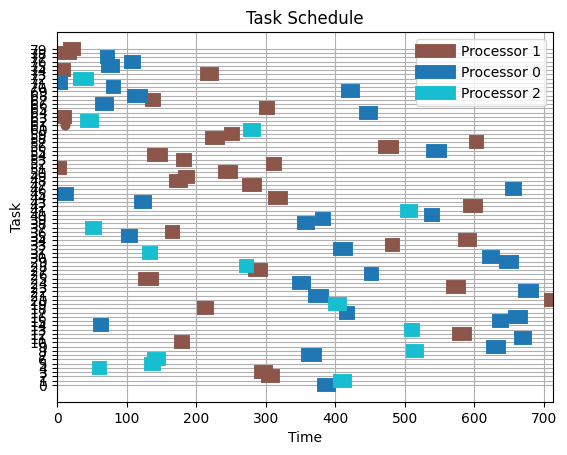

The base schedule makespan is 713
The Updated Context list is :  [(0, 0, 0, 391), (0, 1, 40, 411), (0, 2, 50, 307), (0, 3, 30, 298), (0, 4, 60, 61), (0, 5, 30, 138), (0, 12, 40, 143), (0, 15, 70, 364), (0, 18, 60, 514), (0, 25, 30, 632), (0, 35, 60, 179), (0, 45, 50, 670), (0, 55, 40, 583), (0, 60, 40, 511), (0, 75, 60, 63)]


/usr/local/lib/python3.10/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/usr/local/lib/python3.10/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


In [ ]:

############################################################
#Construct schedule to include context path index, context message ordering
#Begin metascheduling algorithm implementation

#number of context event n
#n = len(contextList)-1                # The first elemnt in the list is excluded as it represents the parent schedule

#print("the value of n = ", n)
contextList_old =[(0,0,0),(0,1,40),(0,2,50),(0,3,30),(0,4,60),(0,5,30),(0,12,40), (0,15,70), (0,18,60), (0,25,30),(0,35,60), (0,45,50),(0,55,40), (0,60,40),(0,75,60)] # 80 Jobs
#compute Base schedule
SMbase, F_genome = generate_schedule_base_schedule(processing_times, message_list, all_path_indexes_with_costs)
#index base schedule as root
print("The Base Schedule Plot is :")
plot_schedule(SMbase)
print('The base schedule makespan is {}'.format(compute_makespan(SMbase)))


#Updating the Context List based on the base Schedule
contextList = Update_Context_List(SMbase, contextList_old)            # 29.09.23
print("The Updated Context list is : ", contextList)
# Modified on Friday 15-09-2023 Omar
AMbase = Read_Parent_AM(json_data)
PMbase = Read_Parent_PM(json_data)

# setSMx=SMbase;// whereSMx is predecessor schedule
SMx = SMbase
AMx = AMbase
PMx = PMbase
Initial_genome = F_genome
c = 0                                             # Context event
volatile_context_list = contextList               # contextList =[(0,0,0),(0,1,40),(0,2,50),(0,3,30)]
Data = [(SMbase, AMbase, PMbase, 0,Initial_genome)]
n=14
def run_metascheduler(n):
    bit_vector = [0] * n  # Initialize the bit vector with all zeros
    #Database_Schedule_indices = []  # Initialize an empty list to store all bit vectors
    iterate_nbit_vector_helper(bit_vector, n, 0,contextList,Data,SMx)


# We loop through n-bit vector
def iterate_nbit_vector_helper(bit_vector, n, index,contextList,Data,SMx):
    if index == n:
        if not (bit_vector == [0] * n):  # Exclude [0, 0, 0]
            #print(bit_vector)  # Do something with the generated bit vector
            Parent_Schedule_Bin,Parent_Schedule_dec = getparent(bit_vector)
            #print("The parent schedule index is :",Parent_Schedule_dec)
            AMx,PMx = getPredecessors(bit_vector,Data)
            AMy, PMy = Apply_Context(AMx,PMx,bit_vector,contextList)
            p= bit_vector_to_value(bit_vector)
            Current_Context_event = find_msb_position(bit_vector)      # 29.09.23 getting the index of the context event
            #print("The current context event is : ",Current_Context_event)
            SMy,Genome, affected_list3 = GA_SOLVE(AMy,PMy,SMx,Data[Parent_Schedule_dec],contextList,Current_Context_event)  # Apply GA , Passing The Dataset as an argument (21-09-23) , Through it i will access the the final genome from GA
                                                                                            # 29.09.23 Context List added in order to appear in the Re-construction scope
                                                                                            # 29.09.23 Current_Context_event added to know what event should be applied in the reconstruction
            #print("The makespan of this schedule is: ",compute_makespan(SMy))
            #plot_schedule(SMy)
            schedule_makespan1 = compute_makespan(SMy)

            #p= bit_vector_to_value(bit_vector)
            Schedule_Communication_Cost_value = len(affected_list3)*5
            D=(SMy,AMy,PMy,p,Genome, Schedule_Communication_Cost_value,schedule_makespan1)
            Data.append(D)
            #print("The Data_base is : " , Data)


        return

    # Recursively generate all possible combinations
    bit_vector[index] = 0
    iterate_nbit_vector_helper(bit_vector, n, index + 1,contextList,Data,SMx)

    bit_vector[index] = 1
    iterate_nbit_vector_helper(bit_vector, n, index + 1,contextList,Data,SMx)

run_metascheduler(n)

## summing over the comm costs

In [ ]:
print(Data)
print(len(Data))
print(Data[31][-1])
print( len(contextList_old))
print(2 ** (len(contextList_old)-1))

In [ ]:
Total_Cost= 0
Avg_Cost = 0
for i in range(1,(len(Data))):
  Total_Cost += Data[i][-2]
  Avg_Cost = Total_Cost/32

print(Total_Cost)
print(Avg_Cost)

583545
18235.78125






## makespan Calculations

In [ ]:
makespan_list= []
for i in range(1,len(Data)):
  #print(Data[i][-1])
  makespan_list.append((Data[i][-1]))

print(makespan_list)
print(len(makespan_list))
print("The Total makesspans is {}".format(sum(makespan_list)+ compute_makespan(SMbase)))

[705, 693, 651, 694, 695, 772, 757, 734, 692, 696, 570, 629, 745, 742, 687, 671, 710, 698, 623, 653, 588, 616, 631, 658, 790, 715, 766, 621, 649, 753, 804, 739, 777, 586, 690, 660, 686, 580, 550, 748, 654, 745, 740, 713, 740, 736, 759, 684, 623, 803, 585, 762, 698, 733, 739, 789, 648, 692, 682, 653, 685, 561, 748, 748, 660, 676, 604, 677, 634, 675, 691, 690, 624, 677, 586, 571, 702, 725, 619, 681, 657, 612, 552, 702, 578, 645, 680, 684, 674, 728, 753, 728, 696, 658, 683, 799, 650, 557, 699, 677, 583, 555, 564, 717, 667, 820, 751, 703, 646, 679, 715, 655, 548, 785, 647, 577, 669, 652, 690, 716, 650, 678, 689, 655, 701, 601, 736, 670, 701, 708, 698, 670, 672, 751, 744, 710, 685, 675, 581, 652, 677, 770, 646, 661, 702, 699, 582, 642, 599, 631, 662, 675, 670, 661, 707, 627, 671, 758, 769, 732, 663, 616, 699, 650, 631, 604, 547, 683, 637, 717, 732, 776, 663, 727, 657, 655, 641, 721, 581, 778, 728, 698, 717, 769, 676, 678, 685, 649, 621, 557, 755, 696, 652, 756, 634, 642, 631, 671, 717, 727,

In [ ]:
len(Data)

## Plotting Schedules

In [ ]:
#len(Data)
#print(Data[31][0])
#plot_schedule(Data[31][0])
#print(compute_makespan(Data[31][0]))

for i in range(len(Data)):
  plot_schedule(Data[i][0])
  print("The makespan for schedule index {} is {}".format((Data[i][-2]), compute_makespan(Data[i][0])))
  #print("The makespan is {}".format(compute_makespan(Data[i][0]))


# **Without factoring the communication cost**

## Helper Functions

In [ ]:
def Read_Parent_AM(json_data):     # Returning a dictionary about the Application graph
  AMx = json_data['application']
  #print("The Parent AM is ",AMx)
  return AMx

def Read_Parent_PM(json_data):     # Returning a dictionary about the Platform graph
  PMx = json_data['platform']
  return PMx


def construct_communication_costs_from_json(json_data):
  messages = json_data['application']['messages']
  communication_costs = {}

  for message in messages:
      sender = message['sender']
      receiver = message['receiver']
      size = message['size']

      if sender not in communication_costs:
          communication_costs[sender] = {receiver: size}
      else:
          communication_costs[sender][receiver] = size

  return communication_costs

def construct_task_dag_from_json(APP_MODEL): # where APP_MODELis an instance from the function Read_Parent_AM(json_data)
    # this function returns 2 lists one for task_dag (list of lists) for the successors
    # Another list tis the wcet_values showing the worst excution times for each job
    jobs = APP_MODEL['jobs']
    messages = APP_MODEL['messages']

    num_tasks = len(jobs)

    # Create a mapping of sender and receiver tasks for each message
    message_mapping = {}
    for message in messages:
        sender = message['sender']
        receiver = message['receiver']
        if sender not in message_mapping:
            message_mapping[sender] = [receiver]
        else:
            message_mapping[sender].append(receiver)

    # Create the task DAG
    task_dag = [[] for _ in range(num_tasks)]

    for job_id, successors in message_mapping.items():
        task_dag[job_id] = successors

    # Extract the WCET values
    wcet_values = [job['processing_times'] for job in jobs]

    return task_dag, wcet_values


def extract_message_list(APP_MODEL):
  # Returns a list of dictionaries for each meassage attribute where the keys for each message will be
  # id,sender,reciever,size
    messages = APP_MODEL['messages']                              # feteching messages (list of dictionaries)
    task_ids = [job['id'] for job in APP_MODEL['jobs']]           # creating a list of task_ids
    message_list = []                                                            # Initializing a list
    for msg in messages:
        sender_id = task_ids.index(msg['sender'])
        receiver_id = task_ids.index(msg['receiver'])
        message_size = msg['size']
        message_id = msg['id']
        message_info = {
            'id': message_id,
            'sender': sender_id,
            'receiver': receiver_id,
            'size': message_size
        }
        message_list.append(message_info)
    return message_list

def compute_makespan(schedule):    # passing the Re-construction function result
    # Extract end times from the schedule
    end_times = [info[2] for info in schedule.values()]
    # The makespan is the maximum end time
    makespan = max(end_times)
    return makespan

def plot_schedule(schedule):
    fig, ax = plt.subplots()

    processors = sorted(list(set([processor for processor, _, _ in schedule.values()])))
    colors = plt.cm.tab10(np.linspace(0, 1, len(processors)))

    for task, (processor, start_time, end_time) in schedule.items():
        color = colors[processor]
        ax.plot([start_time, end_time], [task, task], label=f'Processor {processor}', linewidth=10, marker='o', color=color)

    ax.set_xlabel('Time')
    ax.set_ylabel('Task')

    # Calculate the makespan and set x-axis limit
    makespan = max(end_time for _, (_, _, end_time) in schedule.items())
    ax.set_xlim(0, makespan)

    # Set y-axis ticks and labels
    plt.yticks(range(len(schedule)))
    plt.grid()
    plt.title("Task Schedule")

    # Create a custom legend without duplicate labels
    handles, labels = ax.get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    ax.legend(by_label.values(), by_label.keys())

    plt.show()

def construct_graph_from_json(PLAT_MODEL):         # Function for constructing the PM , returns a graph object
    # Extract nodes and links from JSON data
    nodes = PLAT_MODEL['nodes']
    links = PLAT_MODEL['links']

    # Create an empty graph
    graph = nx.Graph()

    # Add nodes to the graph
    for node in nodes:
        node_id = node['id']
        node_type = 'processor' if not node['is_router'] else 'switch'
        graph.add_node(node_id, node_type=node_type)

    # Add edges (links) to the graph
    for link in links:
        start = link['start']
        end = link['end']
        graph.add_edge(start, end)

    return graph

def generate_all_path_indexes_with_costs(graph):                           # Passing the PM as an argument , geneartes all paths between processors in the graph while calcualting the cost
    processors = [node for node, data in graph.nodes(data=True) if data['node_type'] == 'processor']
    # creating a list with the processor nodes ids
    switches = [node for node, data in graph.nodes(data=True) if data['node_type'] == 'switch']
    # creating a list with the switche nodes ids

    def find_all_paths(source, target, path=[]): # A recursive function to find all paths between a give source node and target node, source and target are the iterables from the below for loop
      # This function uses a depth first search (DFS) to explore the paths
        path = path + [source]                    # Appending the "source" node to the path list, to keep track of nodes vistied in the list
        if source == target:
            return [path]
        if source not in graph:                    # checks for node presence in graph
            return []
        paths = []
        for node in graph[source]:                 # iterating through the current neighbors in graph
            if node not in path:
                newpaths = find_all_paths(node, target, path)  # calling the fuction recursively taking the neighbor node as a source node , target node is the same as the old one, path= path calculated so far
                for newpath in newpaths:
                    paths.append(newpath)
        return paths

    path_indexes = {}                             # Initialzing a dict. to store results (paths and costs)
    path_id = 0
    for source in processors:                     # iterating through the processors list in the PM [0,1,2]
        for target in processors:                 # iterating through processors list in PM [0,1,2], done to consider all pairs between source and target nodes
            if source != target:                  # checking if source and target nodes are not the same as we don't need a path from the processor to itself
                all_paths = find_all_paths(source, target)
                all_paths = [path for path in all_paths if any(node in path for node in switches)] # filtering the paths to keep the ones with only one switch node
                if all_paths:
                    for path in all_paths:
                        # Compute the cost as the number of edges in the path
                        path_cost = len(path) - 1                                   # Computing the cost by subtracting 1 from the number of nodes in the path.
                        # Add the path, its ID, and its cost to the result
                        path_indexes[path_id] = {"path": path, "cost": path_cost}
                        path_id += 1
    return path_indexes

#Python function for n-bit
def value_to_nbit_vector(value, n): # representing teh context event in bit form
    binary = bin(value)[2:]  # Remove the '0b' prefix
    binary = binary.zfill(n)  # Pad with leading zeros to make it n bits long
    bit_vector = [int(bit) for bit in binary]  # Convert each character to integer, bit representation
    return bit_vector

#python function to return the highest bit set (To decode which context event we are dealing with. The value of c)
def find_msb_position(bit_vector):
    msb_position = 0
    for i in range(len(bit_vector)):
        if bit_vector[i] == 1:
            msb_position = len(bit_vector) - i
            break
    return msb_position

#function to convert bit_vector to integer
def bit_vector_to_value(bit_vector):
    value = 0
    n = len(bit_vector)
    for i in range(n):
        value += bit_vector[i] * (2 ** (n - i - 1))
    return value


#This function is to find the equivalent binary value of c bit pattern
def msb_only_bit_vector(bit_vector):
    # Find the position of the most significant bit
    msb_position = find_msb_position(bit_vector)

    # Create a new bit vector with all bits set to 0
    new_bit_vector = [0] * len(bit_vector)

    # Set only the most significant bit to 1
    if msb_position > 0:
        new_bit_vector[-msb_position] = 1

    return new_bit_vector

def getparent(p):# where B is the Database indices and p is the schedule index
  # Assuming p is integer
  Schedule_index = p
  #print('Schedule_index', Schedule_index)
  Context_event_dec = find_msb_position(Schedule_index)
  #print('Context_event_dec', Context_event_dec)


  Context_event_Bin = msb_only_bit_vector(Schedule_index)
  #print("Context_event_Bin",Context_event_Bin)
  Parent_Schedule_Bin = sub_list(Schedule_index,Context_event_Bin)
  #print("Parent_Schedule_Bin",Parent_Schedule_Bin)
  Parent_Schedule_dec = bit_vector_to_value(Parent_Schedule_Bin)
  #print("Parent_Schedule_dec",Parent_Schedule_dec)
  return Parent_Schedule_Bin,Parent_Schedule_dec

def sub_list(list1, list2):                                                # Helper function called in getpredecessors(p)
    if len(list1) != len(list2):
        raise ValueError("Input lists must have the same length")

    result = [a - b for a, b in zip(list1, list2)]
    return result

def Apply_Context(AMx,PMx,p,contextList): # AMx= application model , PMx = Platform model, p = Parent Schedule index in binary
  jobs = AMx['jobs']
  #print("The p in the Apply_Context function is ",p)
  context_event = find_msb_position(p)
  #print("The context event  is :",context_event)
  for context in range(len(contextList)):
    if context == context_event and contextList[context][0] == 0:
      #print("The event {} is a SLACK!!".format(contextList[context]))
      for job in jobs:
        #print(job)
        if job["id"] == contextList[context][1]:
          job["processing_times"]= int(round(job["processing_times"]* (100-contextList[context][2])/100))


          #print("The new AM is : ",AMx)
    elif context == context_event and contextList[context][0] == 1:
      print("The event {} is a Failure!!".format(contextList[context]))
  #print("Function Apply_Context successively applied!!")
  return AMx,PMx

def getPredecessors(p,B): # where the first argument is Binary Encoding of the Schedule, and the second argumet is the Dataset
  Parent_Schedule_Bin,Parent_Schedule_dec = getparent(p) # Calling the helper function to return the parent schedule as decimal and binary value
  #print("The Parent Schedule of {} is {} in binary format and is {} in decimal format".format(p,Parent_Schedule_Bin,Parent_Schedule_dec))   # print check
  context_c = find_msb_position(Parent_Schedule_Bin)    # Getting the context event value of the parent schedule
  #print("The context event of the Parent Schedule is : ",context_c)                      # print check
  for i in range (len(B)): # iterating through the dataset
    if B[i][3] == Parent_Schedule_dec:
      AM,PM = B[i][1], B[i][2]
      #print("Function getPredecessor successfuly deployed ")
      #print("The AMx is {} and the PMx is {}".format(AMx,PMx))

      return AM,PM
      #print("Function getPredecessor successfuly deployed ")
  return None,None


def GA_SOLVE(AMy,PMy,SMx,Data,contextList,Current_Context_event):                             # 29.09.23 ==> adding the Context List &  Current_Context_event attributes
  successors, processing_times = construct_task_dag_from_json(AMy)
  message_list = extract_message_list(AMy)
  PLATFORM_GRAPH_OBJECT = construct_graph_from_json(PMy)
  all_path_indexes_with_costs = generate_all_path_indexes_with_costs(PLATFORM_GRAPH_OBJECT)
  n_tasks = len(processing_times)

  #SMy = generate_schedule_base_schedule(processing_times, message_list, all_path_indexes_with_costs)  # INVOKING GA
  SMy, Genome2 = generate_Successor_schedule2(processing_times, message_list, all_path_indexes_with_costs,Data,contextList,Current_Context_event)       # 29.09.23 Adding the context lIst & Current_Context_event attributes
  return SMy , Genome2

def Update_Context_List(Schedule, contextList):
    for i in range(len(contextList)):
        schedule_info = Schedule.get(i)  # Get the value of the specified key
        if schedule_info:
            start_time = schedule_info[1]
            end_time = schedule_info[2]
            context_time = int(round(start_time + (1 - (contextList[i][2] / 100)) * (end_time - start_time)))
            contextList[i] = contextList[i] + (context_time,)
    return contextList

def Get_Scheduled_task(Data,contextList,Current_Context_event):
  Scheduled_tasks = []
  schedule= Data[0]
  for context in range (len(contextList)):
    if Current_Context_event == context:
      #print(contextList[context])
      current_context = contextList[context]
      for task in schedule:
        #print(task)
        if schedule[task][2] <= current_context[-1]:
          #print(schedule[task])
          Scheduled_tasks.append(task)
  return Scheduled_tasks

def update_lists(Scheduled_tasks, node_list, task_allocation):
    # Create a copy of the original lists to avoid modifying them directly
    updated_node_list = node_list.copy()
    updated_task_allocation = task_allocation.copy()

    for task in Scheduled_tasks:
        while task in updated_node_list:
            # Exclude all occurrences of the task from the node_list
            index = updated_node_list.index(task)
            updated_node_list.pop(index)

            # Exclude the corresponding processor
            updated_task_allocation.pop(index)

    return updated_node_list, updated_task_allocation

def filter_scheduled_tasks(Data, Scheduled_tasks):
    schedule = Data[0]
    scheduled_dict = {}

    for task_id in Scheduled_tasks:
        if task_id in schedule:
            scheduled_dict[task_id] = schedule[task_id]

    return scheduled_dict

# TEST FUNCTIONS

#AMx = Read_Parent_AM(json_data)
#PMx = Read_Parent_PM(json_data)
##print(AMx)
#print(PMx)
#type(AMx)
#successors, processing_times = construct_task_dag_from_json(AMx)
#print(successors)
#print(processing_times)
#message_list = extract_message_list(AMx)
#print(message_list)
#PLATFORM_GRAPH_OBJECT = construct_graph_from_json(PMx)
#print(PLATFORM_GRAPH_OBJECT)
#all_path_indexes_with_costs = generate_all_path_indexes_with_costs(PLATFORM_GRAPH_OBJECT)
#print(all_path_indexes_with_costs)

## Function Instances

In [ ]:
AMx = Read_Parent_AM(json_data)
PMx = Read_Parent_PM(json_data)
successors, processing_times = construct_task_dag_from_json(AMx)
message_list = extract_message_list(AMx)
PLATFORM_GRAPH_OBJECT = construct_graph_from_json(PMx)
all_path_indexes_with_costs = generate_all_path_indexes_with_costs(PLATFORM_GRAPH_OBJECT)
n_tasks = len(processing_times)

## Algorithm 3

In [ ]:
def reconstruct_schedule_with_precedenceX(task_allocation, node_list, processing_times, message_list, message_path_index, all_path_indexes_with_costs, message_priority_ordering):
    # Create a deep copy of the message_list to avoid modifying the original data
    message_list_copy = deepcopy(message_list)            #creating a copy of the message list

    num_processors = max(task_allocation) + 1             # specifing the number of processors
    processors = [[] for _ in range(num_processors)]      # creating a list of empty lists of size = processors

    for task, processor in enumerate(task_allocation):    # Appending the list of processor
        processors[processor].append(task)

    schedule = {}                                         # Initializing a dictionary for the new schedule.
    task_completion_times = [0] * len(node_list)          # Initializing a list of zeros with size = node list
    message_dict = defaultdict(list)                      # creating an instance of defaultdict, it allows define a default value for keys that do not yet exist in the dictionary.
    for i in range(n_tasks):
        message_dict[i] = []                              # Initializing with all potential receivers


    # Create a dictionary to map message ID to priority
    #message_priority_dict = {idx: priority for priority, idx in enumerate(message_priority_ordering)}
    # Modify the message_priority_dict to use actual message IDs
    message_priority_dict = {message_id: priority for priority, message_id in enumerate(message_priority_ordering)}       # Mapping messages to priorities


    for idx, message in enumerate(message_list_copy):
        # Decode the message path index to the corresponding path index
        path_id = message_path_index[idx]
        path = all_path_indexes_with_costs[path_id]["path"]

        path_cost= all_path_indexes_with_costs[path_id]["cost"]

        # Adjust the size of the message with the cost of the path
        message["size"] += path_cost

        # Append a tuple containing the sender, message size, and message priority to the receiver's list in the message_dict
        #message_dict[message["receiver"]].append((message["sender"], message["size"], message_priority_dict[idx]))

        # Use message["id"] to get the priority from message_priority_dict
        message_dict[message["receiver"]].append((message["sender"], message["size"], message_priority_dict[message["id"]]))

    # Sort each receiver's list in message_dict by message priority
    for receiver, messages in message_dict.items():
        message_dict[receiver] = sorted(messages, key=lambda x: x[2])

    current_time_per_processor = [0] * num_processors                 # initilaizing a list of zeros of size = No. of processors
    completed_tasks = set()                                           # creating an empty set for the completed tasks
    ready_tasks = set(range(len(node_list)))                          # A set of random numbers of size = length of node list

    while ready_tasks:                                                # iterating through the set of tasks
        task = ready_tasks.pop()                                      # Acessing a task randomly and removing it from ready tasks set
        task_id = node_list[task]                                     # getting the task id
        processor = task_allocation[task]                             # Acessing the processor on which task should run
        i = processor                                                 # Assigning the value of processor to i

        predecessors = message_dict[task_id]                          # returns a tuple of [(sender,size,id)]
        if all(p in completed_tasks for p, _, _ in predecessors):     # Checks if all pre-decessors(sender in the tuple of predecessors) are in completed tasks set
            if predecessors:
                # Ensure that the start_time is at least the end_time of the last task on this processor
                start_time = max(current_time_per_processor[i], max(task_completion_times[sender] + size for sender, size, _ in predecessors))
            else:
                start_time = current_time_per_processor[i]

            end_time = start_time + processing_times[task_id]
            schedule[task_id] = (i, start_time, end_time)
            task_completion_times[task_id] = end_time

            current_time_per_processor[i] = end_time
            completed_tasks.add(task_id)
        else:
            ready_tasks.add(task)

    return schedule

## Generating Base schedule (ALG 2)

In [ ]:
def generate_schedule_base_schedule(processing_times, message_list, all_path_indexes_with_costs):

  creator.create("FitnessMin", base.Fitness, weights=(-1.0,))     # creating a FitnessMin class for minimization and setting the weights to (-1.0,).
  creator.create("Individual", list, fitness=creator.FitnessMin)  # creating the Individual class as a list with the FitnessMin class as the fitness attribute.

  toolbox = base.Toolbox()

  #parameters
  num_tasks = len(processing_times)                               # No of jobs in task graph
  nodes = json_data["platform"]["nodes"]                          # Accessing the nodes of the Platform model
  #processors = [node for node in nodes if not node["is_router"]]  # Creating  a list of the processors in the Platform model.
  num_machines =2                               # A variable specifing the number of machines
  num_message = len(message_list)                                 # A varible = No. of messages
  num_paths = len(all_path_indexes_with_costs)                    # total number of paths

  # Define the initialization function for the individual
  def init_individual():
      return random.sample(range(num_tasks), num_tasks)           # returns a list of random numbers in the range of num_tasks

  #print('The initial Indidvidual is {}'.format(init_individual()))  # OMAR

  # Register the initialization function in the DEAP toolbox
  toolbox.register("task_order", init_individual)

  #toolbox.register("task_order", tools.initIterate, creator.Individual, init_individual)

  #toolbox.register("task_order", random.sample, range(num_tasks), num_tasks)

  # Processor_allocation value encoding
  def processor_allocation(n_task, n_machines):
      return [random.randint(0, num_machines) for _ in range(n_task)]   # A random list , contains the allocation of each job with the corresponding task
  toolbox.register("processor_allocation", processor_allocation, n_task=num_tasks, n_machines=num_machines)
  HH = toolbox.processor_allocation()                                                     # OMAR
  #print('The randomly initialized task allocation looks as the follows {}'.format(HH))    # OMAR

  # Message_path_index value encoding
  def message_path_index(n_messages, max_all_path_index):
      return [random.randint(0, max_all_path_index - 1) for _ in range(n_messages)]  # Ensure indices are within range
      # returns a list of random numbers of size = n_messages and values ranging from (0, max_all_path_index - 1).

  toolbox.register("message_path_index", message_path_index, n_messages=num_message, max_all_path_index= num_paths)

  #print('The randomly initialized message path looks as the follows {}'.format(toolbox.message_path_index()))    # OMAR


  # Message_priority_ordering permutation encoding
  def message_priority_ordering(n_messages):
      return random.sample(range(n_messages), n_messages)         # returns a list of size = n_messages, showing the messages ordering
  toolbox.register("message_priority_ordering", message_priority_ordering, n_messages=num_message)

  #print('The random priority ordering looks as follows {}'.format(toolbox.message_priority_ordering()))        # OMAR

  # Combined Individual
  def create_individual():
      individual = []
      individual.extend(toolbox.task_order())
      individual.extend(toolbox.processor_allocation())
      individual.extend(toolbox.message_path_index())
      individual.extend(toolbox.message_priority_ordering())
      return individual
  # To view the whole indivudual
  #individual = create_individual()
  #print("Individual:", individual)
  toolbox.register("individual", tools.initIterate, creator.Individual, create_individual)

  #print('The initial combined individual is {}'.format(toolbox.individual()))                  # OMAR

  # Population initialization
  toolbox.register("population", tools.initRepeat, list, toolbox.individual)
  #print('The initial population is {}'.format(toolbox.population(n=100)))

  def reconstruct_schedule(processor_allocation, task_order):
      # Initialize the schedule as a dictionary of empty lists
      # where each key is a processor id
      schedule = {i: [] for i in range(max(processor_allocation) + 1)}

      # Iterate over tasks in their given order
      for task in task_order:
          # Assign each task to its processor
          schedule[processor_allocation[task]].append(task)



      return schedule
  #print ('The Initial Schedule looks as {}'.format(reconstruct_schedule(toolbox.processor_allocation(), toolbox.task_order())))     # OMAR

  ############################################################################################################################################################

  ####################################################### Evaluation, selection, mating, and mutation methods ################################################

  #########compute makespan function ################################################
  def compute_makespan(schedule):
      # Extract end times from the schedule
      end_times = [info[2] for info in schedule.values()]
      # The makespan is the maximum end time
      makespan = max(end_times)
      return makespan
  ################################################################

  # Define the evaluation function
  def evaluate(individual, processing_times, message_list, all_path_indexes_with_costs):
      # Split individual into its components
      task_order_len = num_tasks                  # An Integer with the number of the tasks
      processor_allocation_len = num_tasks        # Integer
      message_path_index_len = num_message        # Integer
      message_priority_ordering_len = num_message # Integer
      task_order = individual[:task_order_len]    # permuation encoding, Acessing the first portion of the chromosome
      processor_allocation = individual[task_order_len:task_order_len + processor_allocation_len] # value encoding acessing the second portion of chromosomes
      message_path_index = individual[task_order_len + processor_allocation_len : task_order_len + processor_allocation_len + message_path_index_len] # value encoding
      message_priority_ordering = individual[task_order_len + processor_allocation_len + message_path_index_len :] # permuation encoding
      # print("task_order ================", task_order)
      # print("processor_allocation ================", processor_allocation)
      # print("message_path_index ================", message_path_index)
      # print("message_priority_ordering ================", message_priority_ordering)
      schedule = reconstruct_schedule_with_precedenceX(processor_allocation, task_order, processing_times, message_list, message_path_index, all_path_indexes_with_costs, message_priority_ordering)
      makespan  = compute_makespan(schedule)
      fitness = 1.0 / (makespan)
      #print("Makespan over time is %s, %s", makespan)
      #scheduleR = reconstruct_schedule(processor_allocation, task_order)
      # You would need to split the individual into its parts and use these parts to calculate the makespan
      # For the sake of this example, let's just return the sum of all elements in the individual
      return fitness,

  # Register the evaluation function
  toolbox.register("evaluate", evaluate,processing_times=processing_times,
                  message_list=message_list, all_path_indexes_with_costs=all_path_indexes_with_costs)

  # Register selection operator
  toolbox.register("select", tools.selTournament, tournsize=3) # Applying tournament selection, tournsize=3
                                                               # meaning three individuals will be randomly selected from the population,
                                                               # and the best one among them will be chosen as a parent for the next generation.


  # Register the crossover operator (Permutation encoded)
  def mate(ind1, ind2, task_order_len):
      # Copy the individuals
      child1, child2 = toolbox.clone(ind1), toolbox.clone(ind2) # creating copies from ind1 and ind2 to preserve original originals while crossover and mutation.

      # Apply PMX crossover to task_order
      tools.cxPartialyMatched(child1[:task_order_len], child2[:task_order_len]) # Applying partially matched crossover method

      # Return the modified individuals
      return child1, child2

  toolbox.register("mate", mate, task_order_len=num_tasks)                # Register the crossover function


  #toolbox.register("mate", tools.cxTwoPoint)


  # mutation operators
  # def mutation_task_order(individual, task_order_len):
  #     task_order = individual[:task_order_len] # permutation encoding
  #     random.shuffle(task_order) # Shuffle the indexes of task_order
  #     individual[:task_order_len] = task_order
  #     return individual,
  def mutation_task_order(individual, task_order_len):
      task_order = individual[:task_order_len]  # permutation encoding
      indices = random.sample(range(task_order_len), 2)  # Select two random indices
      task_order[indices[0]], task_order[indices[1]] = task_order[indices[1]], task_order[indices[0]]  # Swap the elements at the selected indices
      individual[:task_order_len] = task_order
      return individual,

  def mutation_processor_allocation(individual,task_order_len, processor_allocation_len): # (task_order_len = processor_allocation_len)
      processor_allocation = individual[task_order_len:task_order_len + processor_allocation_len] # value encoding
      tools.mutUniformInt(processor_allocation, low=0, up=1, indpb=0.05) # Mutate processor_allocation by uniformly changing its elements with an indpb chance
      individual[task_order_len:task_order_len + processor_allocation_len] = processor_allocation
      return individual,

  def mutation_message_path_index(individual, task_order_len, processor_allocation_len, message_path_index_len):
      message_path_index = individual[task_order_len + processor_allocation_len : task_order_len + processor_allocation_len + message_path_index_len] # value encoding
      tools.mutUniformInt(message_path_index, low=0, up=1, indpb=0.05) # Mutate message_path_index by uniformly changing its elements with an indpb chance
      individual[task_order_len + processor_allocation_len : task_order_len + processor_allocation_len + message_path_index_len] = message_path_index
      return individual,

  def mutation_message_priority_ordering(individual, task_order_len, processor_allocation_len, message_path_index_len):
      message_priority_ordering = individual[task_order_len + processor_allocation_len + message_path_index_len :] # permuation encoding
      tools.mutShuffleIndexes(message_priority_ordering, indpb=0.05) # Mutate message_priority_ordering by shuffling its indexes with an indpb chance
      individual[task_order_len + processor_allocation_len + message_path_index_len :] = message_priority_ordering
      return individual,

  # register the mutation operators
  toolbox.register("mutate_task_order", mutation_task_order, task_order_len = num_tasks)
  toolbox.register("mutate_processor_allocation", mutation_processor_allocation, task_order_len = num_tasks, processor_allocation_len = num_tasks)
  toolbox.register("mutate_message_path_index", mutation_message_path_index, task_order_len = num_tasks, processor_allocation_len = num_tasks, message_path_index_len = num_message)
  toolbox.register("mutate_message_priority_ordering", mutation_message_priority_ordering, task_order_len = num_tasks, processor_allocation_len = num_tasks, message_path_index_len = num_message)

  ######################################################
  # Create an initial population
  pop = toolbox.population(n=100)
  # Evaluate the entire population
  fitnesses = map(toolbox.evaluate, pop)
  for ind, fit in zip(pop, fitnesses):
      ind.fitness.values = fit
  # Crossover probability and mutation probability
  CXPB, MUTPB = 0.3, 0.2

  # Extract all the fitnesses of
  fits = [ind.fitness.values[0] for ind in pop]

  NGEN = 50 #Number of generations
  # Begin the evolution
  for g in range(NGEN):
      # A new generation
      offspring = toolbox.select(pop, len(pop)) # Apply the tournmnet selection , 3 individulas will be selected
      # Clone the selected individuals
      offspring = list(map(toolbox.clone, offspring))

      # Apply crossover and mutation on the offspring
      for child1, child2 in zip(offspring[::2], offspring[1::2]):
          if random.random() < CXPB:
              toolbox.mate(child1, child2) # Applying crossover for Permutation encoding (task orders)
              del child1.fitness.values
              del child2.fitness.values
      # mutation
      for mutant in offspring:
          if random.random() < MUTPB:
              toolbox.mutate_task_order(mutant)
              toolbox.mutate_processor_allocation(mutant)
              toolbox.mutate_message_path_index(mutant)
              toolbox.mutate_message_priority_ordering(mutant)
              del mutant.fitness.values

      # Evaluate the individuals with an invalid fitness
      invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
      fitnesses = map(toolbox.evaluate, invalid_ind)
      for ind, fit in zip(invalid_ind, fitnesses):
          ind.fitness.values = fit
      # The population is entirely replaced by the offspring
      pop[:] = offspring
  # Print the best individual
  best_ind = tools.selBest(pop, 1)[0]
  #print("Best individual is %s, %s" % (best_ind, best_ind.fitness.values))




  task_order_len = num_tasks
  processor_allocation_len = num_tasks
  message_path_index_len = num_message
  message_priority_ordering_len = num_message
  task_order = best_ind[:task_order_len]
  processor_allocation = best_ind[task_order_len:task_order_len + processor_allocation_len] #value encoding
  message_path_index = best_ind[task_order_len + processor_allocation_len : task_order_len + processor_allocation_len + message_path_index_len] #value encoding
  message_priority_ordering = best_ind[task_order_len + processor_allocation_len + message_path_index_len :] #permuation encoding
  # print("task_order ================", task_order)
  # print("processor_allocation ================", processor_allocation)
  # print("message_path_index ================", message_path_index)
  # print("message_priority_ordering ================", message_priority_ordering)
  scheduleFinal = reconstruct_schedule_with_precedenceX(processor_allocation, task_order, processing_times, message_list, message_path_index, all_path_indexes_with_costs, message_priority_ordering)
  #print('The final schedule is {}'.format(scheduleFinal))
  Final_genome= [task_order,processor_allocation,message_path_index,message_priority_ordering]
  return scheduleFinal , Final_genome



#scheduleFinal, Final_genome= generate_schedule_base_schedule(processing_times, message_list, all_path_indexes_with_costs)

#makespanFinal  = compute_makespan(scheduleFinal)

#plot_schedule(scheduleFinal)
#print('The final schedule makespan is {}'.format(makespanFinal))
#print("The Final Genome for this schdule is {}".format(Final_genome))

## Reconstruction 2

In [ ]:
def reconstruct_schedule_with_precedenceXX(task_allocation, node_list, processing_times, message_list, message_path_index, all_path_indexes_with_costs, message_priority_ordering,Data,contextList,Current_Context_event): # New 21-09-23
  # Data ==> has only information about the previous schedule
  # Create a deep copy of the message_list to avoid modifying the original data
    message_list_copy = deepcopy(message_list)            #creating a copy of the message list

    #print("The previous Data is : ",Data)



   # Call Affected_ES function to get the list of affected processors
    #affected_processors = Affected_ES(Data, node_list, task_allocation, message_path_index, message_priority_ordering)


    # New Modifications (1) 29-09-23
    Scheduled_tasks = Get_Scheduled_task(Data,contextList,Current_Context_event)   # Returns a list of tasks that where previously scheduled
    #print("The Scheduled Tasks are",Scheduled_tasks )

    # New Modification (2) 29-09-23
    new_node_list , new_task_allocation = update_lists(Scheduled_tasks, node_list, task_allocation)
    #print("The node_list after update is: ",new_node_list)
    #print("The Task_allocation after update is:", new_task_allocation)

    # New Modification (3) 29.09.23
    Partial_Schedule = filter_scheduled_tasks(Data, Scheduled_tasks)
    #print("The unchanged part from the parent schedule is :", Partial_Schedule)

    num_processors = max(task_allocation) + 1             # specifing the number of processors
    processors = [[] for _ in range(num_processors)]      # creating a list of empty lists of size = processors

    for task, processor in enumerate(new_task_allocation):    # Appending the list of processor
        processors[processor].append(task)

    n_tasks = len(new_node_list)
    schedule = {}                                         # Initializing a dictionary for the new schedule.
    task_completion_times = [0] * len(node_list)          # Initializing a list of zeros with size = node list
    message_dict = defaultdict(list)                      # creating an instance of defaultdict, it allows define a default value for keys that do not yet exist in the dictionary.
    for i in range(n_tasks):
        message_dict[i] = []                              # Initializing with all potential receivers




    # Create a dictionary to map message ID to priority
    #message_priority_dict = {idx: priority for priority, idx in enumerate(message_priority_ordering)}
    # Modify the message_priority_dict to use actual message IDs
    message_priority_dict = {message_id: priority for priority, message_id in enumerate(message_priority_ordering)}       # Mapping messages to priorities


    for idx, message in enumerate(message_list_copy):
        # Decode the message path index to the corresponding path index
        path_id = message_path_index[idx]
        path = all_path_indexes_with_costs[path_id]["path"]

        path_cost= all_path_indexes_with_costs[path_id]["cost"]

        # Adjust the size of the message with the cost of the path
        message["size"] += path_cost

        # Append a tuple containing the sender, message size, and message priority to the receiver's list in the message_dict
        #message_dict[message["receiver"]].append((message["sender"], message["size"], message_priority_dict[idx]))

        # Use message["id"] to get the priority from message_priority_dict
        message_dict[message["receiver"]].append((message["sender"], message["size"], message_priority_dict[message["id"]]))

    # Sort each receiver's list in message_dict by message priority
    for receiver, messages in message_dict.items():
        message_dict[receiver] = sorted(messages, key=lambda x: x[2])

    current_time_per_processor = [contextList[Current_Context_event][-1]] * num_processors    # 29.09.23 Updating the start time based on the context event time
    #print("The current time per processor list ",current_time_per_processor)
    completed_tasks = set()                                           # creating an empty set for the completed tasks
    completed_tasks = set(Partial_Schedule.keys())                    # 09.10.2023 edited

    ready_tasks = set(range(len(new_node_list)))                          # A set of random numbers of size = length of node list
    #print("Ready tasks are",ready_tasks)


    while ready_tasks:                                                # iterating through the set of tasks
        task = ready_tasks.pop()                                      # Acessing a task randomly and removing it from ready tasks set
        #print("The Task in read_tasks look is :",task)
        task_id = new_node_list[task]                                     # getting the task id
        #print("The task_id in ready_tasks loop is",task_id)
        processor = new_task_allocation[task]                             # Acessing the processor on which task should run
        #print("The corresponding processor is :",processor)
        i = processor                                                 # Assigning the value of processor to i

        # Introduce fixed delay for affected processors
        #if processor in affected_processors:
            #current_time_per_processor[processor] += 5
        #print("The processor times are :",current_time_per_processor)

        predecessors = message_dict[task_id]                          # returns a tuple of [(sender,size,id)]
        #print("The predecessors are ",predecessors)
        if all(p in completed_tasks for p, _, _ in predecessors):     # Checks if all pre-decessors(sender in the tuple of predecessors) are in completed tasks set
            #print("ïnside the if ")
            if predecessors:
                # Ensure that the start_time is at least the end_time of the last task on this processor
                start_time = max(current_time_per_processor[i], max(task_completion_times[sender] + size for sender, size, _ in predecessors))
                #print("The start_time is :",start_time)
            else:
                start_time = current_time_per_processor[i]
                #print("The start time in else is :",start_time)

            end_time = start_time + processing_times[task_id]
            #print("The endtime is : ",end_time)
            schedule[task_id] = (i, start_time, end_time)
            task_completion_times[task_id] = end_time

            current_time_per_processor[i] = end_time
            completed_tasks.add(task_id)
        else:
            ready_tasks.add(task)
    #print("The Previous genome is : ",Data[-1])

    merged_schedule = deepcopy(Partial_Schedule)  # creating  a copy of Partial_Schedule (predecessor)
    merged_schedule.update(schedule)

    return merged_schedule


# Test
#task_allocation= [1, 0, 1, 1, 0, 0, 2, 2, 2, 2, 0]
#node_list =      [9, 3, 7, 1, 0, 5, 4, 10, 8, 2, 6]
#message_path_index = [0, 1, 0, 1, 1, 9, 1, 4, 1, 6, 1, 3, 0, 9]
#message_priority_ordering = [2, 9, 1, 5, 13, 6, 7, 12, 11, 3, 10, 4, 8, 0]
#Data = ({0: (0, 0, 2), 1: (1, 11, 15), 5: (1, 22, 25), 9: (1, 32, 35), 3: (1, 35, 40), 4: (1, 40, 44), 8: (1, 51, 55), 7: (1, 55, 60), 2: (1, 60, 64), 6: (1, 70, 72), 10: (1, 78, 80)}, {'jobs': [{'id': 0, 'processing_times': 2, 'mcet': 10, 'deadline': 250, 'can_run_on': [0, 1, 2]}, {'id': 1, 'processing_times': 2, 'mcet': 10, 'deadline': 250, 'can_run_on': [0, 1, 2]}, {'id': 2, 'processing_times': 4, 'mcet': 10, 'deadline': 300, 'can_run_on': [0, 1, 2]}, {'id': 3, 'processing_times': 5, 'mcet': 10, 'deadline': 256, 'can_run_on': [0, 1, 2]}, {'id': 4, 'processing_times': 4, 'mcet': 10, 'deadline': 256, 'can_run_on': [0, 1, 2]}, {'id': 5, 'processing_times': 3, 'mcet': 10, 'deadline': 256, 'can_run_on': [0, 1, 2]}, {'id': 6, 'processing_times': 2, 'mcet': 10, 'deadline': 256, 'can_run_on': [0, 1, 2]}, {'id': 7, 'processing_times': 5, 'mcet': 10, 'deadline': 256, 'can_run_on': [0, 1, 2]}, {'id': 8, 'processing_times': 4, 'mcet': 10, 'deadline': 256, 'can_run_on': [0, 1, 2]}, {'id': 9, 'processing_times': 3, 'mcet': 10, 'deadline': 256, 'can_run_on': [0, 1, 2]}, {'id': 10, 'processing_times': 2, 'mcet': 10, 'deadline': 256, 'can_run_on': [0, 1, 2]}], 'messages': [{'id': 0, 'sender': 0, 'receiver': 1, 'size': 6, 'timetriggered': True}, {'id': 1, 'sender': 0, 'receiver': 2, 'size': 2, 'timetriggered': True}, {'id': 2, 'sender': 0, 'receiver': 3, 'size': 3, 'timetriggered': True}, {'id': 3, 'sender': 0, 'receiver': 4, 'size': 4, 'timetriggered': True}, {'id': 4, 'sender': 1, 'receiver': 5, 'size': 4, 'timetriggered': True}, {'id': 5, 'sender': 1, 'receiver': 9, 'size': 6, 'timetriggered': True}, {'id': 6, 'sender': 2, 'receiver': 6, 'size': 2, 'timetriggered': True}, {'id': 7, 'sender': 3, 'receiver': 7, 'size': 4, 'timetriggered': True}, {'id': 8, 'sender': 4, 'receiver': 8, 'size': 3, 'timetriggered': True}, {'id': 9, 'sender': 4, 'receiver': 7, 'size': 2, 'timetriggered': True}, {'id': 10, 'sender': 5, 'receiver': 9, 'size': 4, 'timetriggered': True}, {'id': 11, 'sender': 6, 'receiver': 10, 'size': 2, 'timetriggered': True}, {'id': 12, 'sender': 7, 'receiver': 10, 'size': 3, 'timetriggered': True}, {'id': 13, 'sender': 9, 'receiver': 10, 'size': 2, 'timetriggered': True}]}, {'nodes': [{'id': 0, 'is_router': False}, {'id': 1, 'is_router': False}, {'id': 2, 'is_router': False}, {'id': 3, 'is_router': True}, {'id': 4, 'is_router': True}, {'id': 5, 'is_router': True}, {'id': 6, 'is_router': True}, {'id': 7, 'is_router': True}, {'id': 8, 'is_router': True}, {'id': 9, 'is_router': True}], 'links': [{'start': 0, 'end': 7}, {'start': 1, 'end': 7}, {'start': 7, 'end': 8}, {'start': 2, 'end': 8}, {'start': 3, 'end': 8}, {'start': 4, 'end': 8}, {'start': 8, 'end': 9}, {'start': 7, 'end': 9}, {'start': 5, 'end': 9}, {'start': 6, 'end': 9}], 'frequencies': [500, 1000], 'schemes': [{'id': 0, 'wcdt': 0, 'wcct': 0, 'wccr': 1}, {'id': 1, 'wcdt': 10, 'wcct': 10, 'wccr': 0.5}]}, 0, [[9, 3, 4, 8, 10, 7, 2, 6, 0, 1, 5], [1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1], [1, 8, 5, 7, 1, 0, 5, 0, 9, 9, 8, 9, 0, 1], [6, 7, 0, 11, 2, 4, 3, 12, 1, 13, 5, 9, 8, 10]])

#contextList = [(0, 0, 0, 2), (0, 1, 40, 13), (0, 2, 50, 37), (0, 3, 30, 60), (0, 4, 60, 41), (0, 5, 30, 25)]
#Current_Context_event = 2
#x = reconstruct_schedule_with_precedenceXX(task_allocation, node_list, processing_times, message_list, message_path_index, all_path_indexes_with_costs, message_priority_ordering,Data,contextList,Current_Context_event)
#print(x)

## New GA

In [ ]:
def generate_Successor_schedule2(processing_times, message_list, all_path_indexes_with_costs,Data,contextList,Current_Context_event): # 29.09.23 adding contextList & Current_Context_event as attributes

  creator.create("FitnessMin", base.Fitness, weights=(-1.0,))     # creating a FitnessMin class for minimization and setting the weights to (-1.0,).
  creator.create("Individual", list, fitness=creator.FitnessMin)  # creating the Individual class as a list with the FitnessMin class as the fitness attribute.

  toolbox = base.Toolbox()

  #parameters
  num_tasks = len(processing_times)                               # No of jobs in task graph
  nodes = json_data["platform"]["nodes"]                          # Accessing the nodes of the Platform model
  #processors = [node for node in nodes if not node["is_router"]]  # Creating  a list of the processors in the Platform model.
  num_machines = 2                               # A variable specifing the number of machines
  num_message = len(message_list)                                 # A varible = No. of messages
  num_paths = len(all_path_indexes_with_costs)                    # total number of paths

  # Define the initialization function for the individual
  def init_individual():
      return random.sample(range(num_tasks), num_tasks)           # returns a list of random numbers in the range of num_tasks

  #print('The initial Indidvidual is {}'.format(init_individual()))  # OMAR

  # Register the initialization function in the DEAP toolbox
  toolbox.register("task_order", init_individual)

  #toolbox.register("task_order", tools.initIterate, creator.Individual, init_individual)

  #toolbox.register("task_order", random.sample, range(num_tasks), num_tasks)

  # Processor_allocation value encoding
  def processor_allocation(n_task, n_machines):
      return [random.randint(0, num_machines) for _ in range(n_task)]   # A random list , contains the allocation of each job with the corresponding task
  toolbox.register("processor_allocation", processor_allocation, n_task=num_tasks, n_machines=num_machines)
  HH = toolbox.processor_allocation()                                                     # OMAR
  #print('The randomly initialized task allocation looks as the follows {}'.format(HH))    # OMAR

  # Message_path_index value encoding
  def message_path_index(n_messages, max_all_path_index):
      return [random.randint(0, max_all_path_index - 1) for _ in range(n_messages)]  # Ensure indices are within range
      # returns a list of random numbers of size = n_messages and values ranging from (0, max_all_path_index - 1).

  toolbox.register("message_path_index", message_path_index, n_messages=num_message, max_all_path_index= num_paths)

  #print('The randomly initialized message path looks as the follows {}'.format(toolbox.message_path_index()))    # OMAR


  # Message_priority_ordering permutation encoding
  def message_priority_ordering(n_messages):
      return random.sample(range(n_messages), n_messages)         # returns a list of size = n_messages, showing the messages ordering
  toolbox.register("message_priority_ordering", message_priority_ordering, n_messages=num_message)

  #print('The random priority ordering looks as follows {}'.format(toolbox.message_priority_ordering()))        # OMAR

  # Combined Individual
  def create_individual():
      individual = []
      individual.extend(toolbox.task_order())
      individual.extend(toolbox.processor_allocation())
      individual.extend(toolbox.message_path_index())
      individual.extend(toolbox.message_priority_ordering())
      return individual
  # To view the whole indivudual
  #individual = create_individual()
  #print("Individual:", individual)
  toolbox.register("individual", tools.initIterate, creator.Individual, create_individual)

  #print('The initial combined individual is {}'.format(toolbox.individual()))                  # OMAR

  # Population initialization
  toolbox.register("population", tools.initRepeat, list, toolbox.individual)
  #print('The initial population is {}'.format(toolbox.population(n=100)))

  def reconstruct_schedule(processor_allocation, task_order):
      # Initialize the schedule as a dictionary of empty lists
      # where each key is a processor id
      schedule = {i: [] for i in range(max(processor_allocation) + 1)}

      # Iterate over tasks in their given order
      for task in task_order:
          # Assign each task to its processor
          schedule[processor_allocation[task]].append(task)



      return schedule
  #print ('The Initial Schedule looks as {}'.format(reconstruct_schedule(toolbox.processor_allocation(), toolbox.task_order())))     # OMAR

  ############################################################################################################################################################

  ####################################################### Evaluation, selection, mating, and mutation methods ################################################

  #########compute makespan function ################################################
  def compute_makespan(schedule):
      # Extract end times from the schedule
      end_times = [info[2] for info in schedule.values()]
      # The makespan is the maximum end time
      makespan = max(end_times)
      return makespan
  ################################################################

  # Define the evaluation function
  def evaluate(individual, processing_times, message_list, all_path_indexes_with_costs):
      # Split individual into its components
      task_order_len = num_tasks                  # An Integer with the number of the tasks
      processor_allocation_len = num_tasks        # Integer
      message_path_index_len = num_message        # Integer
      message_priority_ordering_len = num_message # Integer
      task_order = individual[:task_order_len]    # permuation encoding, Acessing the first portion of the chromosome
      processor_allocation = individual[task_order_len:task_order_len + processor_allocation_len] # value encoding acessing the second portion of chromosomes
      message_path_index = individual[task_order_len + processor_allocation_len : task_order_len + processor_allocation_len + message_path_index_len] # value encoding
      message_priority_ordering = individual[task_order_len + processor_allocation_len + message_path_index_len :] # permuation encoding
      # print("task_order ================", task_order)
      # print("processor_allocation ================", processor_allocation)
      # print("message_path_index ================", message_path_index)
      # print("message_priority_ordering ================", message_priority_ordering)
      schedule = reconstruct_schedule_with_precedenceX(processor_allocation, task_order, processing_times, message_list, message_path_index, all_path_indexes_with_costs, message_priority_ordering)
      makespan  = compute_makespan(schedule)
      fitness = 1.0 / (makespan)
      #print("Makespan over time is %s, %s", makespan)
      #scheduleR = reconstruct_schedule(processor_allocation, task_order)
      # You would need to split the individual into its parts and use these parts to calculate the makespan
      # For the sake of this example, let's just return the sum of all elements in the individual
      return fitness,

  # Register the evaluation function
  toolbox.register("evaluate", evaluate,processing_times=processing_times,
                  message_list=message_list, all_path_indexes_with_costs=all_path_indexes_with_costs)

  # Register selection operator
  toolbox.register("select", tools.selTournament, tournsize=3) # Applying tournament selection, tournsize=3
                                                               # meaning three individuals will be randomly selected from the population,
                                                               # and the best one among them will be chosen as a parent for the next generation.


  # Register the crossover operator (Permutation encoded)
  def mate(ind1, ind2, task_order_len):
      # Copy the individuals
      child1, child2 = toolbox.clone(ind1), toolbox.clone(ind2) # creating copies from ind1 and ind2 to preserve original originals while crossover and mutation.

      # Apply PMX crossover to task_order
      tools.cxPartialyMatched(child1[:task_order_len], child2[:task_order_len]) # Applying partially matched crossover method

      # Return the modified individuals
      return child1, child2

  toolbox.register("mate", mate, task_order_len=num_tasks)                # Register the crossover function


  #toolbox.register("mate", tools.cxTwoPoint)


  # mutation operators
  # def mutation_task_order(individual, task_order_len):
  #     task_order = individual[:task_order_len] # permutation encoding
  #     random.shuffle(task_order) # Shuffle the indexes of task_order
  #     individual[:task_order_len] = task_order
  #     return individual,
  def mutation_task_order(individual, task_order_len):
      task_order = individual[:task_order_len]  # permutation encoding
      indices = random.sample(range(task_order_len), 2)  # Select two random indices
      task_order[indices[0]], task_order[indices[1]] = task_order[indices[1]], task_order[indices[0]]  # Swap the elements at the selected indices
      individual[:task_order_len] = task_order
      return individual,

  def mutation_processor_allocation(individual,task_order_len, processor_allocation_len): # (task_order_len = processor_allocation_len)
      processor_allocation = individual[task_order_len:task_order_len + processor_allocation_len] # value encoding
      tools.mutUniformInt(processor_allocation, low=0, up=1, indpb=0.05) # Mutate processor_allocation by uniformly changing its elements with an indpb chance
      individual[task_order_len:task_order_len + processor_allocation_len] = processor_allocation
      return individual,

  def mutation_message_path_index(individual, task_order_len, processor_allocation_len, message_path_index_len):
      message_path_index = individual[task_order_len + processor_allocation_len : task_order_len + processor_allocation_len + message_path_index_len] # value encoding
      tools.mutUniformInt(message_path_index, low=0, up=1, indpb=0.05) # Mutate message_path_index by uniformly changing its elements with an indpb chance
      individual[task_order_len + processor_allocation_len : task_order_len + processor_allocation_len + message_path_index_len] = message_path_index
      return individual,

  def mutation_message_priority_ordering(individual, task_order_len, processor_allocation_len, message_path_index_len):
      message_priority_ordering = individual[task_order_len + processor_allocation_len + message_path_index_len :] # permuation encoding
      tools.mutShuffleIndexes(message_priority_ordering, indpb=0.05) # Mutate message_priority_ordering by shuffling its indexes with an indpb chance
      individual[task_order_len + processor_allocation_len + message_path_index_len :] = message_priority_ordering
      return individual,

  # register the mutation operators
  toolbox.register("mutate_task_order", mutation_task_order, task_order_len = num_tasks)
  toolbox.register("mutate_processor_allocation", mutation_processor_allocation, task_order_len = num_tasks, processor_allocation_len = num_tasks)
  toolbox.register("mutate_message_path_index", mutation_message_path_index, task_order_len = num_tasks, processor_allocation_len = num_tasks, message_path_index_len = num_message)
  toolbox.register("mutate_message_priority_ordering", mutation_message_priority_ordering, task_order_len = num_tasks, processor_allocation_len = num_tasks, message_path_index_len = num_message)

  ######################################################
  # Create an initial population
  pop = toolbox.population(n=100)
  # Evaluate the entire population
  fitnesses = map(toolbox.evaluate, pop)
  for ind, fit in zip(pop, fitnesses):
      ind.fitness.values = fit
  # Crossover probability and mutation probability
  CXPB, MUTPB = 0.3, 0.2

  # Extract all the fitnesses of
  fits = [ind.fitness.values[0] for ind in pop]

  NGEN = 50 #Number of generations
  # Begin the evolution
  for g in range(NGEN):
      # A new generation
      offspring = toolbox.select(pop, len(pop)) # Apply the tournmnet selection , 3 individulas will be selected
      # Clone the selected individuals
      offspring = list(map(toolbox.clone, offspring))

      # Apply crossover and mutation on the offspring
      for child1, child2 in zip(offspring[::2], offspring[1::2]):
          if random.random() < CXPB:
              toolbox.mate(child1, child2) # Applying crossover for Permutation encoding (task orders)
              del child1.fitness.values
              del child2.fitness.values
      # mutation
      for mutant in offspring:
          if random.random() < MUTPB:
              toolbox.mutate_task_order(mutant)
              toolbox.mutate_processor_allocation(mutant)
              toolbox.mutate_message_path_index(mutant)
              toolbox.mutate_message_priority_ordering(mutant)
              del mutant.fitness.values

      # Evaluate the individuals with an invalid fitness
      invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
      fitnesses = map(toolbox.evaluate, invalid_ind)
      for ind, fit in zip(invalid_ind, fitnesses):
          ind.fitness.values = fit
      # The population is entirely replaced by the offspring
      pop[:] = offspring
  # Print the best individual
  best_ind = tools.selBest(pop, 1)[0]
  #print("Best individual is %s, %s" % (best_ind, best_ind.fitness.values))




  task_order_len = num_tasks
  processor_allocation_len = num_tasks
  message_path_index_len = num_message
  message_priority_ordering_len = num_message
  task_order = best_ind[:task_order_len]
  processor_allocation = best_ind[task_order_len:task_order_len + processor_allocation_len] #value encoding
  message_path_index = best_ind[task_order_len + processor_allocation_len : task_order_len + processor_allocation_len + message_path_index_len] #value encoding
  message_priority_ordering = best_ind[task_order_len + processor_allocation_len + message_path_index_len :] #permuation encoding
  # print("task_order ================", task_order)
  # print("processor_allocation ================", processor_allocation)
  # print("message_path_index ================", message_path_index)
  # print("message_priority_ordering ================", message_priority_ordering)
  scheduleFinal = reconstruct_schedule_with_precedenceXX(processor_allocation, task_order, processing_times, message_list, message_path_index, all_path_indexes_with_costs, message_priority_ordering,Data,contextList,Current_Context_event)      # Editing the re-construction (New 21-09-23)
                                                                                                                                                                                                                                                  # 29.09.23 adding contextList,Current_Context_event as attributes
  #print('The final schedule is {}'.format(scheduleFinal))
  Final_genome= [task_order,processor_allocation,message_path_index,message_priority_ordering]
  return scheduleFinal , Final_genome




## ALG 1

In [ ]:

############################################################
#Construct schedule to include context path index, context message ordering
#Begin metascheduling algorithm implementation

#number of context event n
#n = len(contextList)-1                # The first elemnt in the list is excluded as it represents the parent schedule

#print("the value of n = ", n)
contextList_old =[(0,0,0),(0,1,40),(0,2,50),(0,3,30),(0,4,60),(0,5,30),(0,12,40), (0,15,70), (0,18,60), (0,25,30),(0,35,60), (0,45,50),(0,55,40), (0,60,40),(0,75,60)] # 80 Jobs
#compute Base schedule
SMbase, F_genome = generate_schedule_base_schedule(processing_times, message_list, all_path_indexes_with_costs)
#index base schedule as root
print("The Base Schedule Plot is :")
plot_schedule(SMbase)
print('The base schedule makespan is {}'.format(compute_makespan(SMbase)))


#Updating the Context List based on the base Schedule
contextList = Update_Context_List(SMbase, contextList_old)            # 29.09.23

print("The Updated Context list is : ", contextList)
# Modified on Friday 15-09-2023 Omar
AMbase = Read_Parent_AM(json_data)
PMbase = Read_Parent_PM(json_data)

# setSMx=SMbase;// whereSMx is predecessor schedule
SMx = SMbase
AMx = AMbase
PMx = PMbase
Initial_genome = F_genome
c = 0                                             # Context event
volatile_context_list = contextList               # contextList =[(0,0,0),(0,1,40),(0,2,50),(0,3,30)]
Data = [(SMbase, AMbase, PMbase, 0,Initial_genome)]
n=14
def run_metascheduler(n):
    bit_vector = [0] * n  # Initialize the bit vector with all zeros
    #Database_Schedule_indices = []  # Initialize an empty list to store all bit vectors
    iterate_nbit_vector_helper(bit_vector, n, 0,contextList,Data,SMx)


# We loop through n-bit vector
def iterate_nbit_vector_helper(bit_vector, n, index,contextList,Data,SMx):
    if index == n:
        if not (bit_vector == [0] * n):  # Exclude [0, 0, 0]
            #print(bit_vector)  # Do something with the generated bit vector
            Parent_Schedule_Bin,Parent_Schedule_dec = getparent(bit_vector)
            #print("The parent schedule index is :",Parent_Schedule_dec)
            AMx,PMx = getPredecessors(bit_vector,Data)
            AMy, PMy = Apply_Context(AMx,PMx,bit_vector,contextList)
            p= bit_vector_to_value(bit_vector)
            Current_Context_event = find_msb_position(bit_vector)      # 29.09.23 getting the index of the context event
            #print("The current context event is : ",Current_Context_event)
            SMy,Genome = GA_SOLVE(AMy,PMy,SMx,Data[Parent_Schedule_dec],contextList,Current_Context_event)  # Apply GA , Passing The Dataset as an argument (21-09-23) , Through it i will access the the final genome from GA
                                                                                            # 29.09.23 Context List added in order to appear in the Re-construction scope
                                                                                            # 29.09.23 Current_Context_event added to know what event should be applied in the reconstruction
            schedule_makespan = compute_makespan(SMy)
            #print("The makespan of this schedule is: ",schedule_makespan)
            #plot_schedule(SMy)

            #p= bit_vector_to_value(bit_vector)

            D=(SMy,AMy,PMy,p,Genome,schedule_makespan)
            Data.append(D)


        return

    # Recursively generate all possible combinations
    bit_vector[index] = 0
    iterate_nbit_vector_helper(bit_vector, n, index + 1,contextList,Data,SMx)

    bit_vector[index] = 1
    iterate_nbit_vector_helper(bit_vector, n, index + 1,contextList,Data,SMx)

run_metascheduler(n)


## Calculating the communication cost

In [ ]:
print("The Data_base is : " , Data)


In [ ]:
makespan_list = []
for i in range(1,2 ** n):
  makespan_list.append(Data[i][-1])

print(makespan_list)


sampling_freq = 10
context_information_cost = 5

result_list = []

for element in makespan_list:
    result = round((element / sampling_freq) * context_information_cost)
    result_list.append(result)



print(result_list)

print(sum(result_list))

In [ ]:
sum(makespan_list)

In [ ]:
with open('/content/drive/MyDrive/Dataoutput60jobs.txt', 'w') as writefile:
  for item in Data:
        # write each item on a new line
        writefile.write("%s\n" % item)
